# Load necessary libraries and packages

In [219]:
import openpiv.tools
import openpiv.process
import openpiv.scaling
import openpiv.validation
import openpiv.filters

import cv2
import imutils
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

# Plot vector field

In [220]:
def display_vector_field( frame_counter, filename, on_img=False, image_name='None', window_size=32, scaling_factor=1, **kw):
    """ Displays quiver plot of the data stored in the file 
    
    
    Parameters
    ----------
    filename :  string
        the absolute path of the text file

    on_img : Bool, optional
        if True, display the vector field on top of the image provided by image_name

    image_name : string, optional
        path to the image to plot the vector field onto when on_img is True

    window_size : int, optional
        when on_img is True, provide the interogation window size to fit the background image to the vector field

    scaling_factor : float, optional
        when on_img is True, provide the scaling factor to scale the background image to the vector field
    
    Key arguments   : (additional parameters, optional)
        *scale*: [None | float]
        *width*: [None | float]
    
    
    See also:
    ---------
    matplotlib.pyplot.quiver
    
        
    Examples
    --------
    --- only vector field
    >>> openpiv.tools.display_vector_field('./exp1_0000.txt',scale=100, width=0.0025) 

    --- vector field on top of image
    >>> openpiv.tools.display_vector_field('./exp1_0000.txt', on_img=True, image_name='exp1_001_a.bmp', window_size=32, scaling_factor=70, scale=100, width=0.0025)
    
    """
    
    a = np.loadtxt(filename)
    fig=pl.figure()
    pl.hold(True)
    if on_img: # plot a background image
        im = imread(image_name)
        im = negative(im) #plot negative of the image for more clarity
        imsave('neg.tif', im)
        im = mpltimg.imread('neg.tif')
        xmax=np.amax(a[:,0])+window_size/(2*scaling_factor)
        ymax=np.amax(a[:,1])+window_size/(2*scaling_factor)
        implot = pl.imshow(im, origin='lower', cmap="Greys_r",extent=[0.,xmax,0.,ymax])
        pl.show()
    invalid = a[:,4].astype('bool')
    fig.canvas.set_window_title('Vector field, '+str(np.count_nonzero(invalid))+' wrong vectors')
    valid = ~invalid
    pl.quiver(a[invalid,0],a[invalid,1],a[invalid,2],a[invalid,3],color='r',**kw)
    #pl.quiver(a[valid,0],a[valid,1],a[valid,2],a[valid,3],color='b',**kw)
    figure = pl.gcf()
    pl.draw()
    pl.show()
    figure.savefig('vf_img_%s.png'%frame_counter)

# Define PIV vector field 

In [221]:
def vector_field(frame_one, frame_two, frame_counter):
    # arg1: previous frame
    # arg2: current frame
    # Perform cross-correlation with a window from frame one over the entirety of frame two to ultimately produce a 
    # single vector field.
    winsize = 36 # pixels
    searchsize = 64  # pixels, search in image two
    overlap = 12 # pixels
    dt = 0.033 # sec
    u0, v0, sig2noise = openpiv.process.extended_search_area_piv( frame_one.astype(np.int32), frame_two.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )
    x, y = openpiv.process.get_coordinates( image_size=frame_one.shape, window_size=winsize, overlap=overlap )
    u1, v1, mask = openpiv.validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.3 )
    u2, v2 = openpiv.filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)
    x, y, u3, v3 = openpiv.scaling.uniform(x, y, u2, v2, scaling_factor = 96.52 )
    openpiv.tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )
    display_vector_field(frame_counter, 'exp1_001.txt', scale=100, width=0.0025)

# Read in video

In [222]:
cap = cv2.VideoCapture('brewing_video.mp4')

# Display video and threshold

/home/tim/anaconda3/envs/opiv_env/lib/python2.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


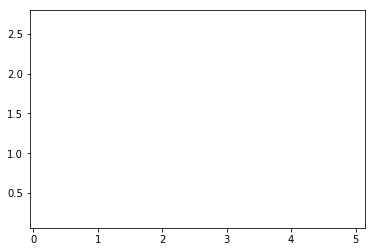

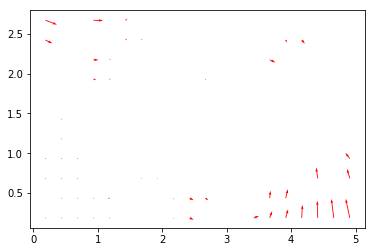

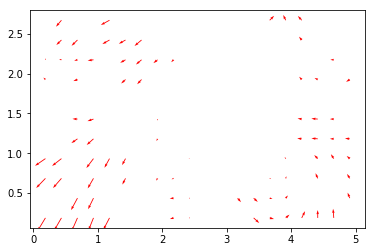

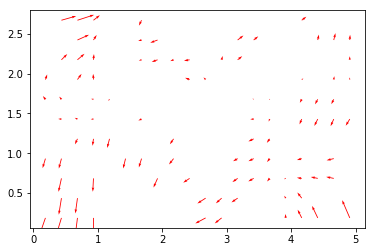

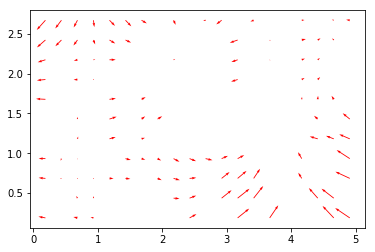

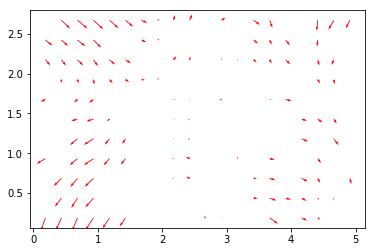

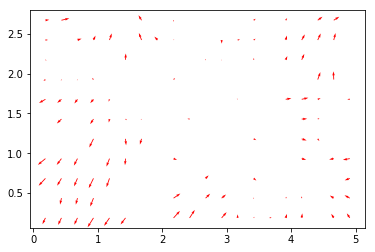

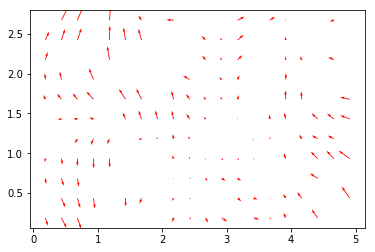

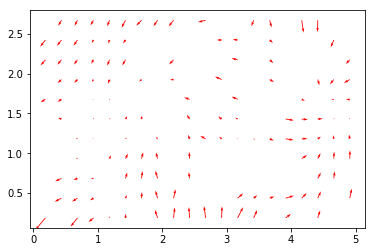

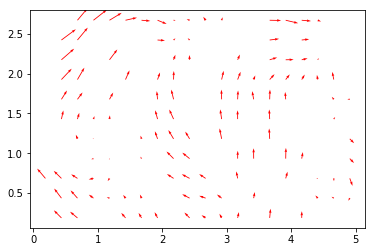

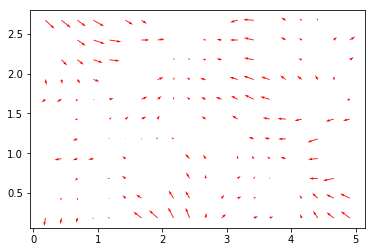

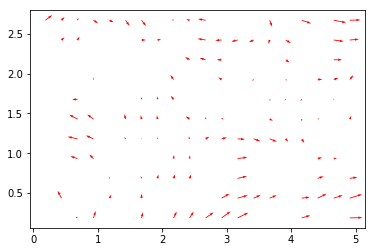

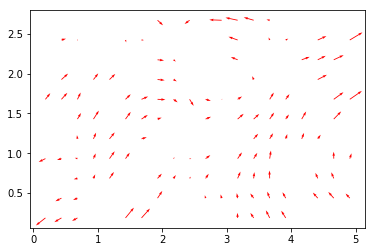

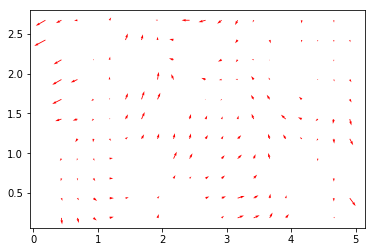

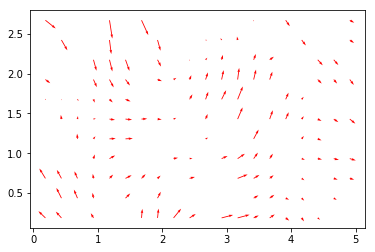

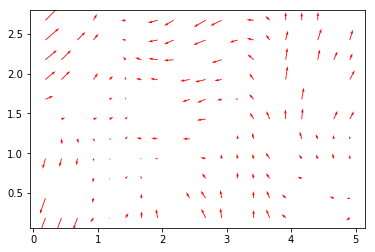

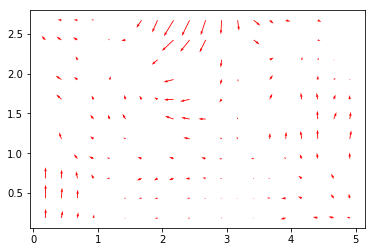

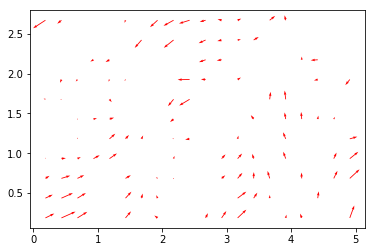

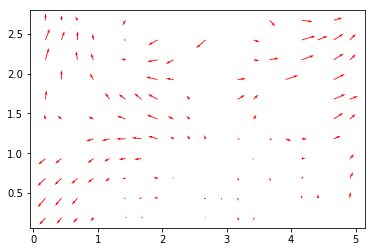

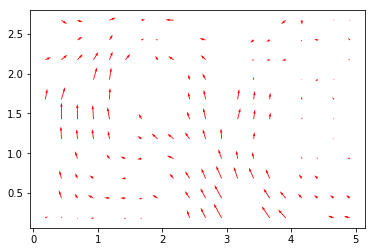

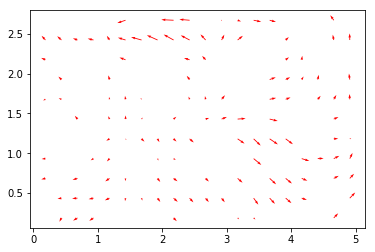

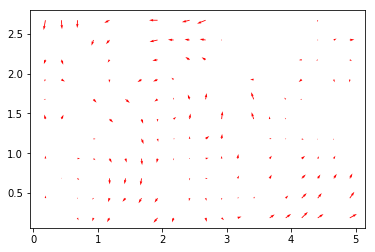

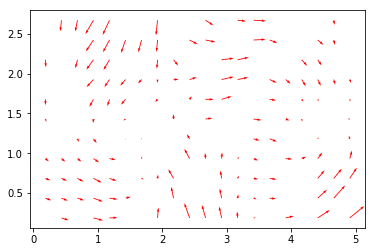

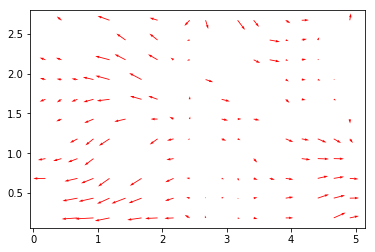

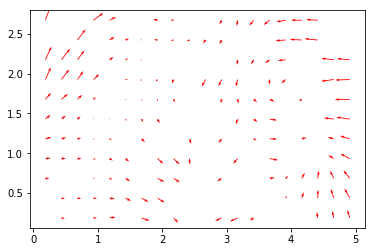

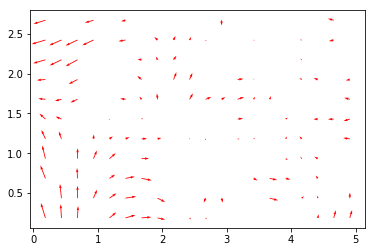

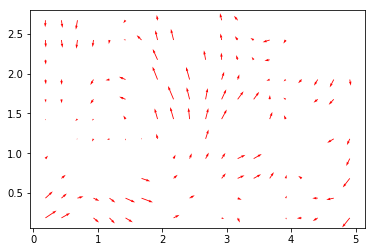

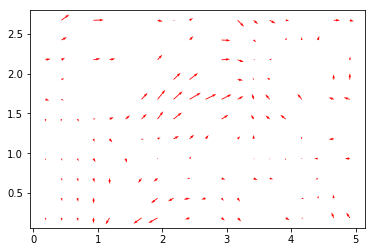

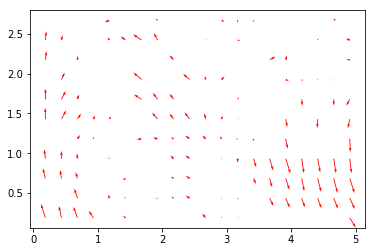

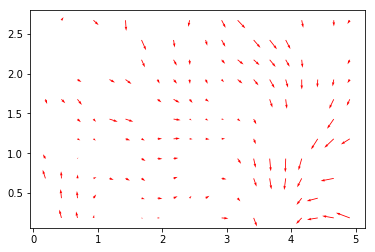

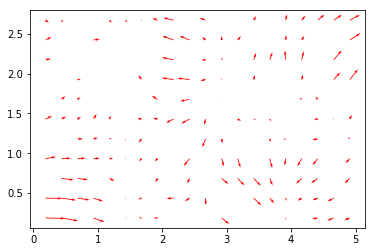

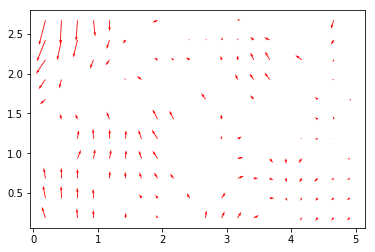

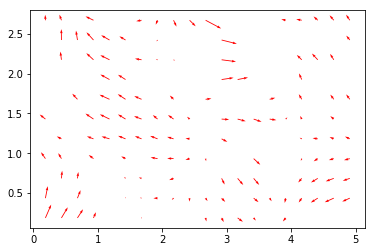

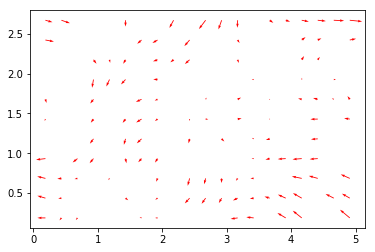

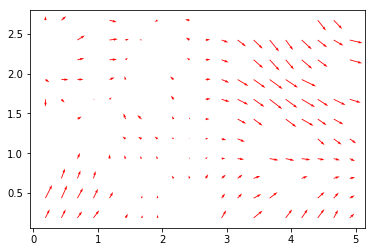

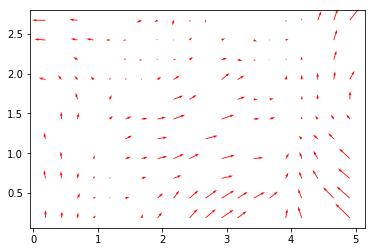

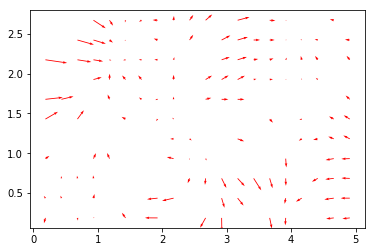

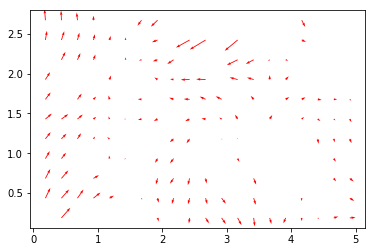

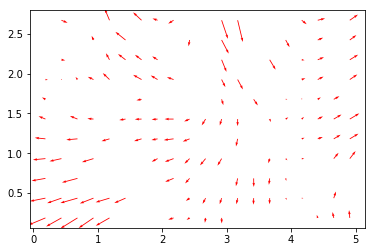

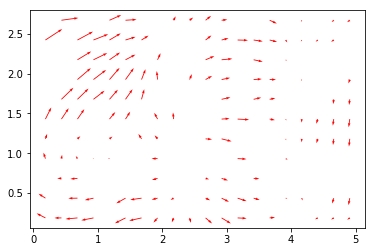

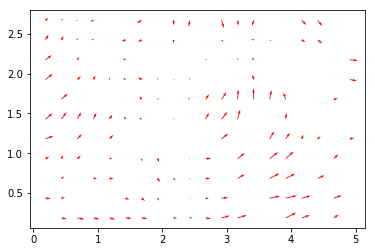

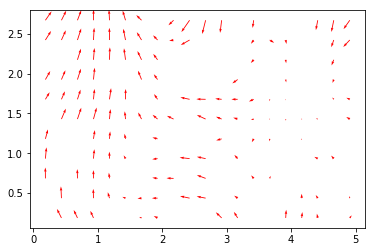

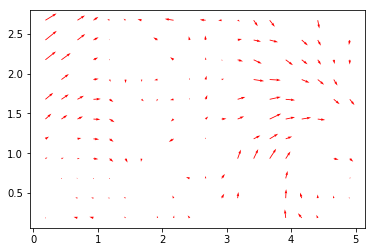

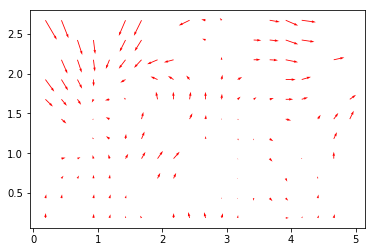

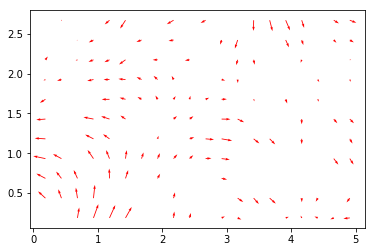

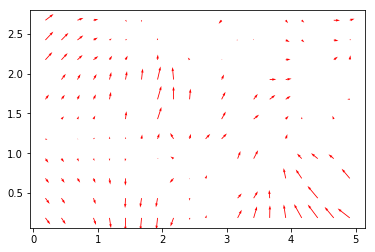

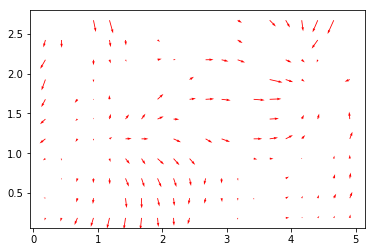

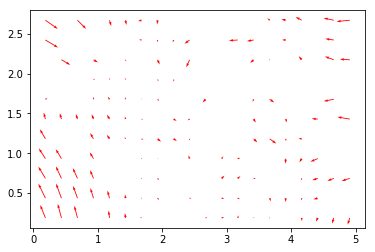

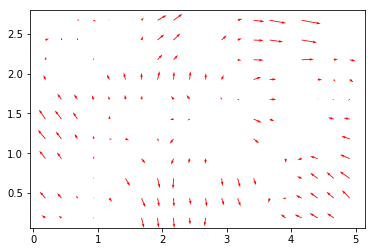

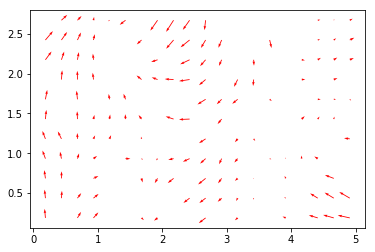

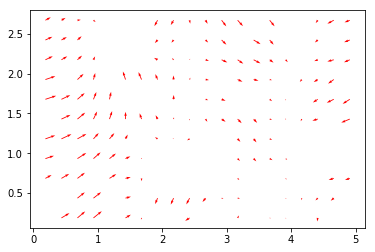

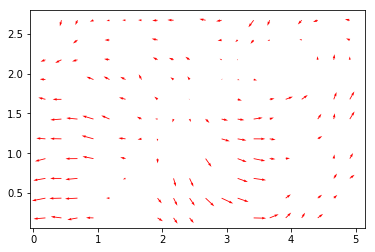

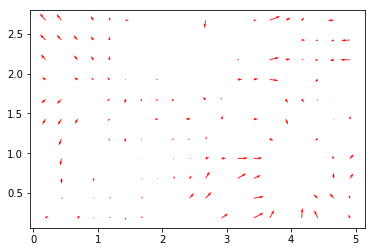

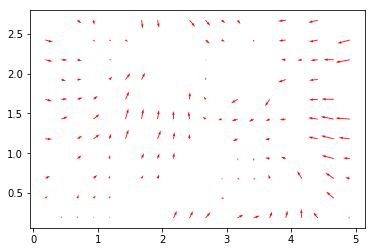

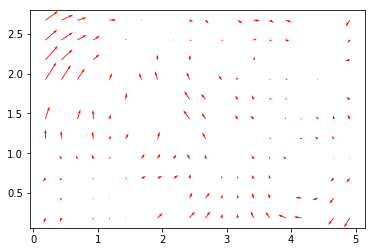

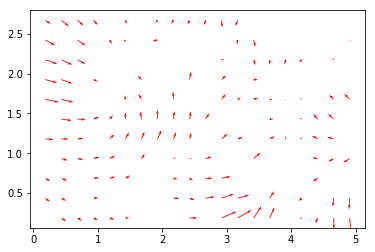

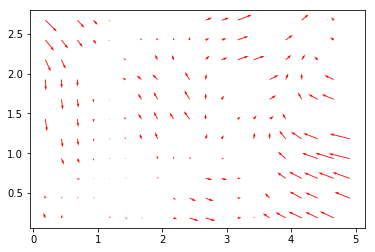

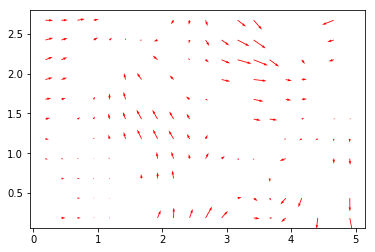

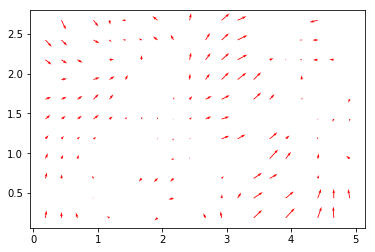

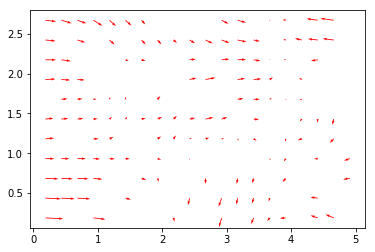

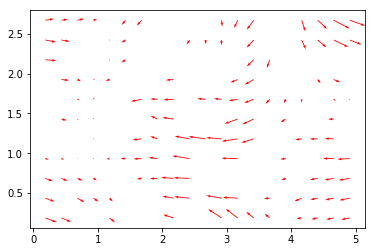

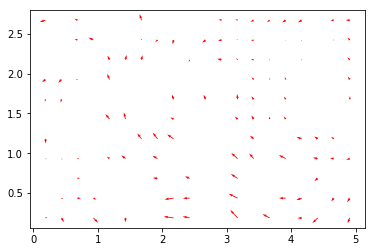

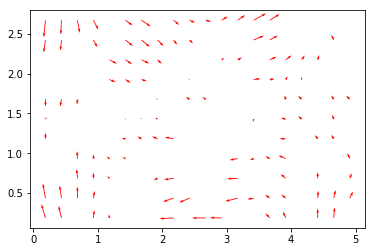

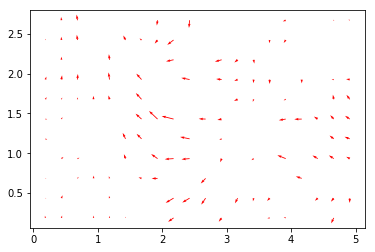

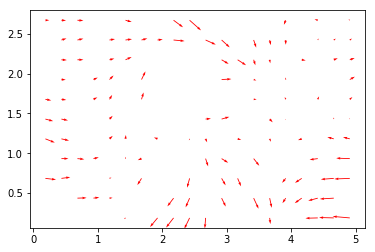

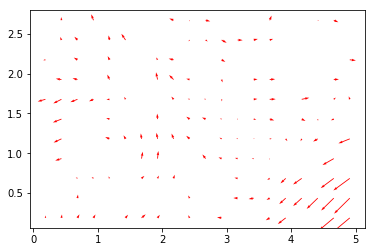

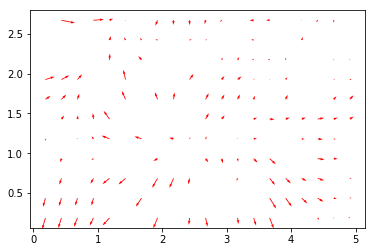

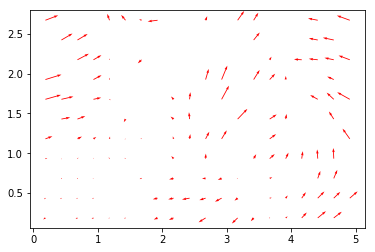

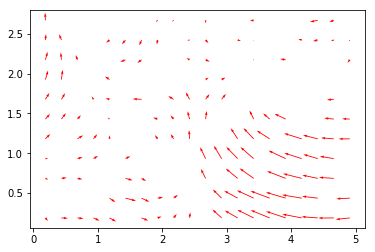

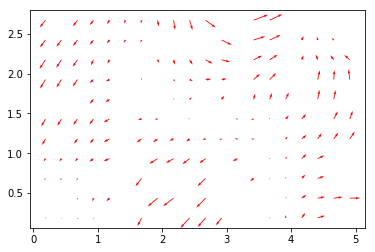

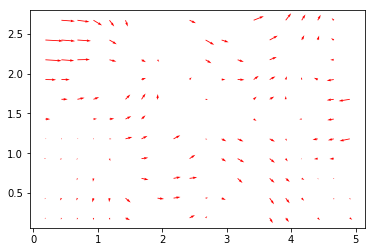

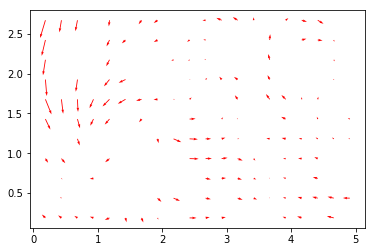

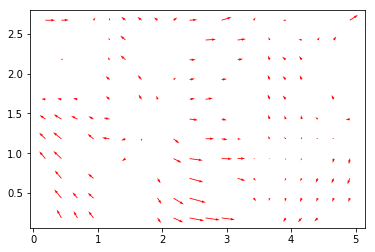

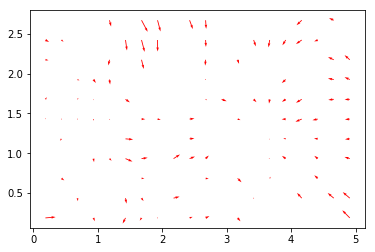

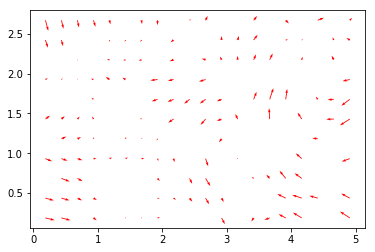

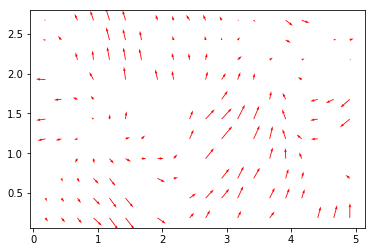

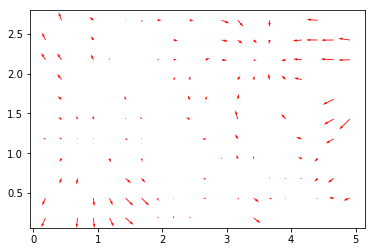

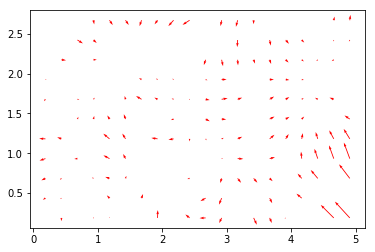

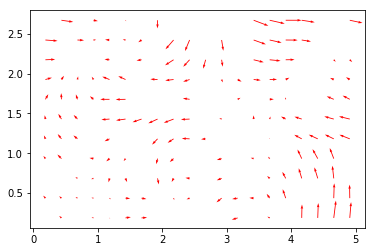

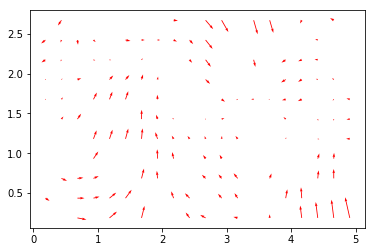

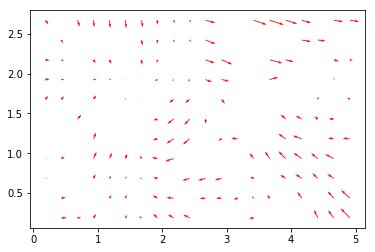

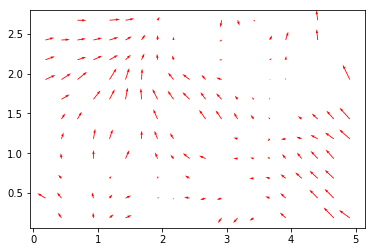

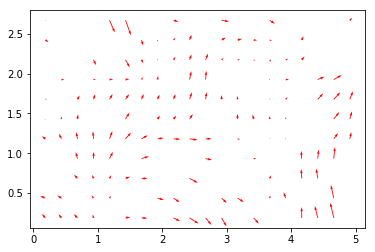

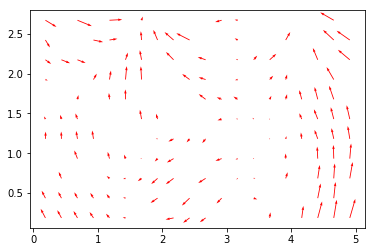

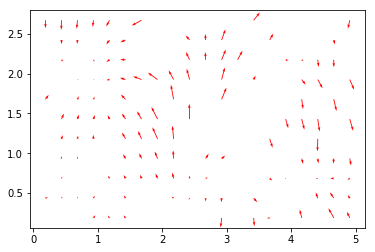

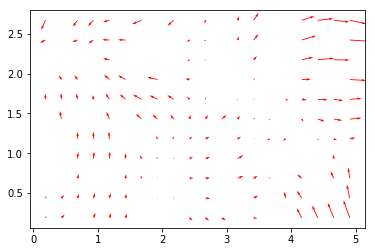

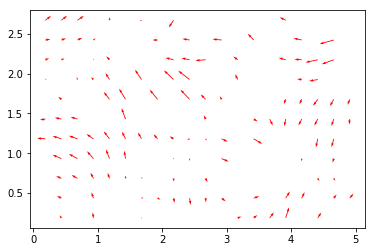

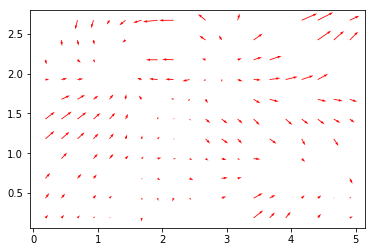

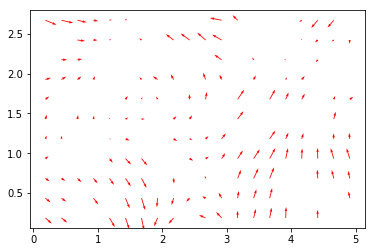

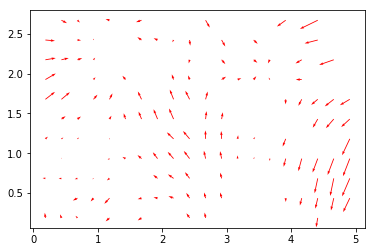

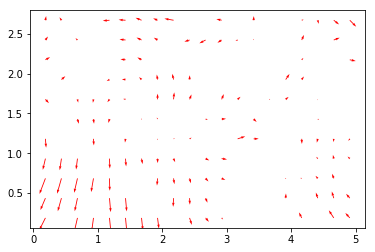

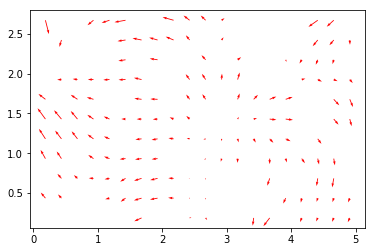

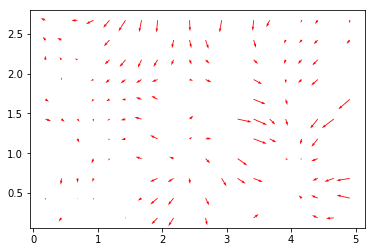

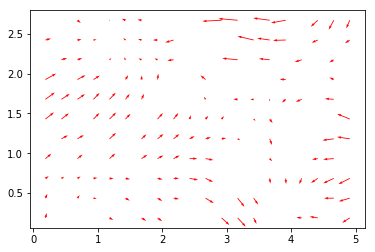

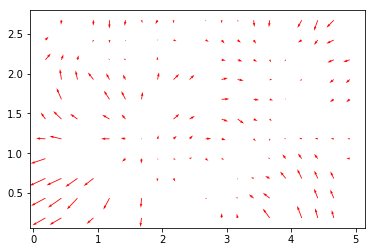

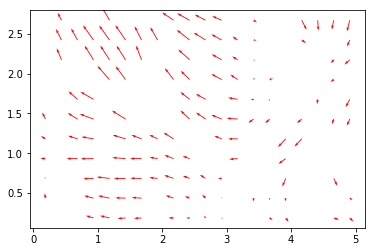

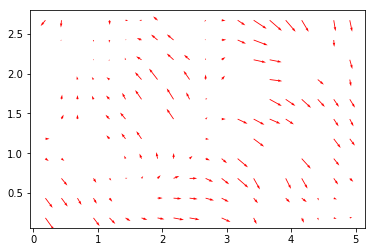

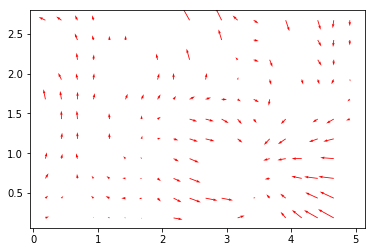

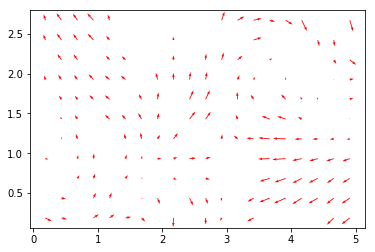

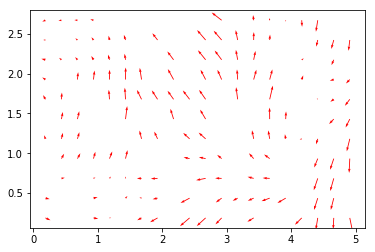

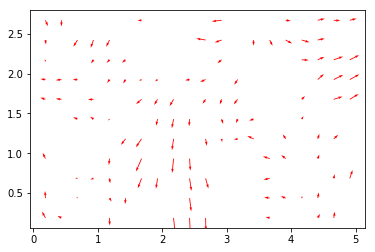

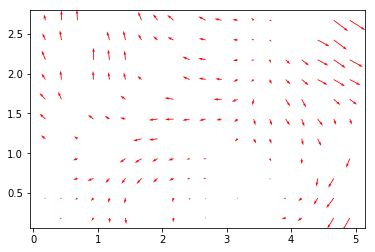

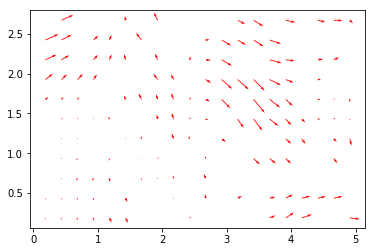

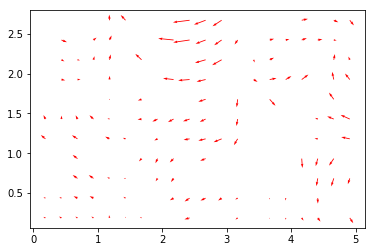

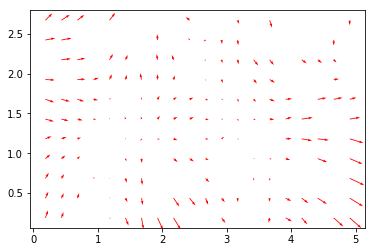

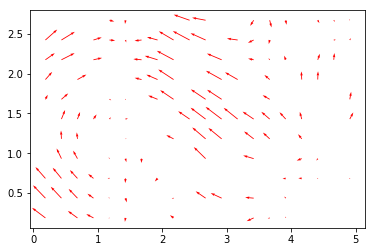

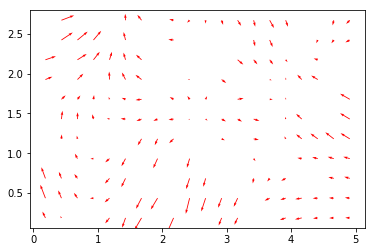

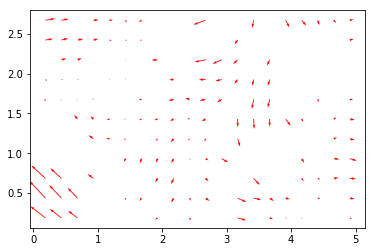

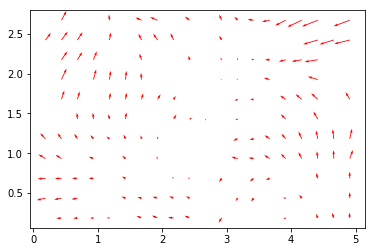

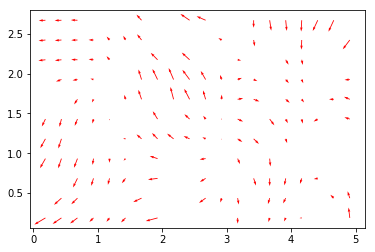

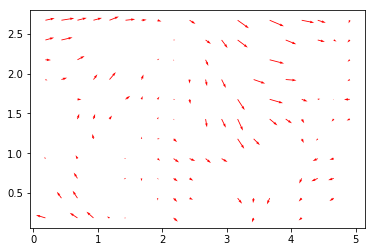

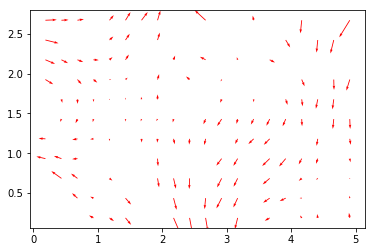

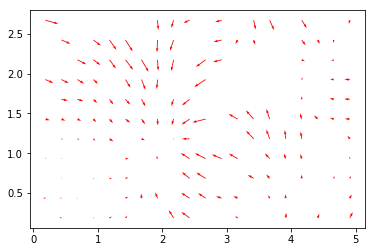

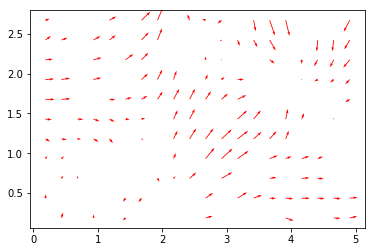

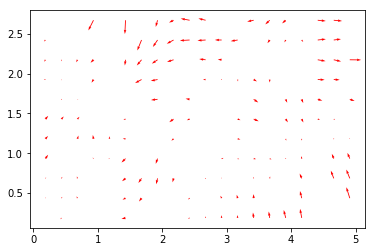

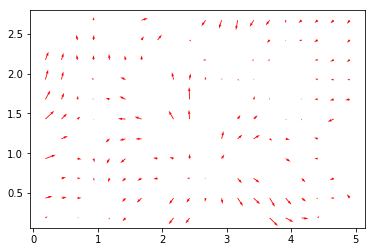

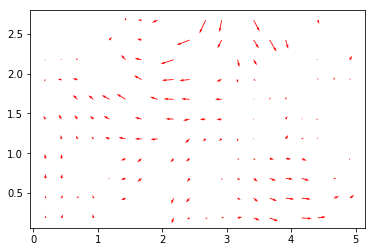

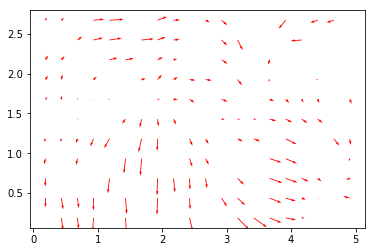

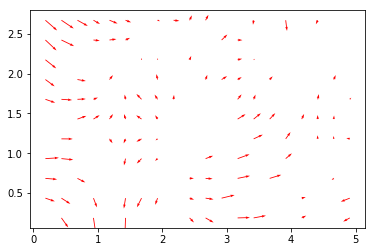

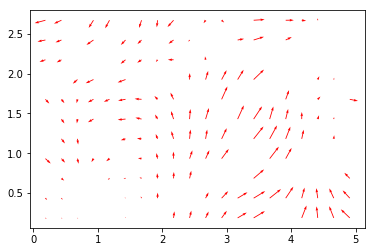

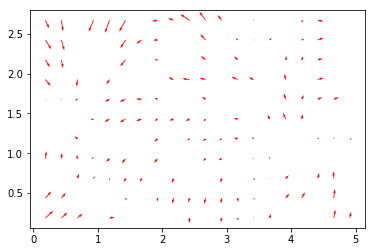

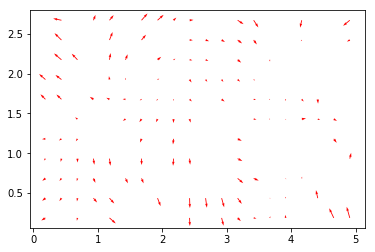

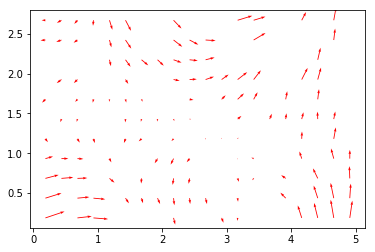

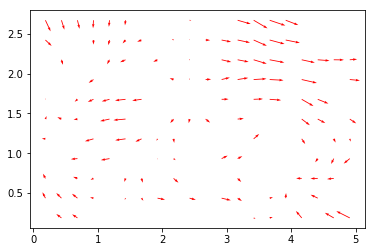

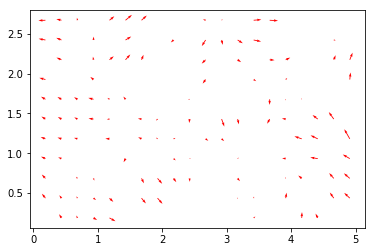

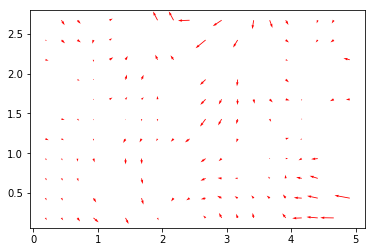

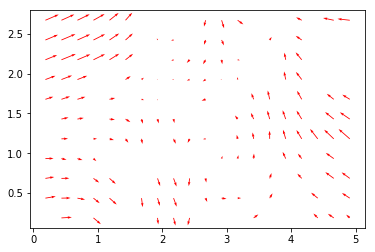

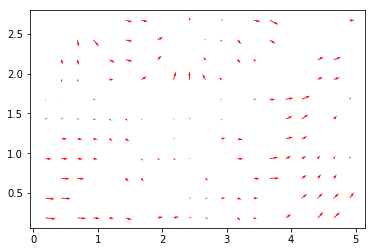

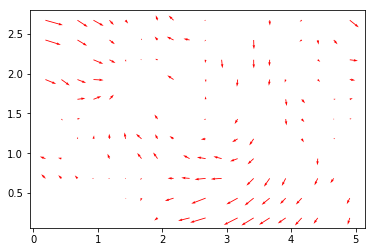

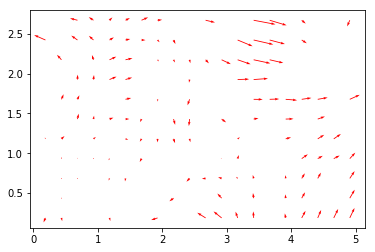

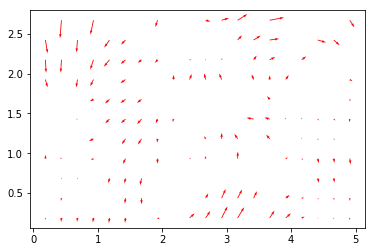

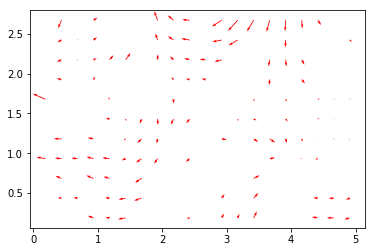

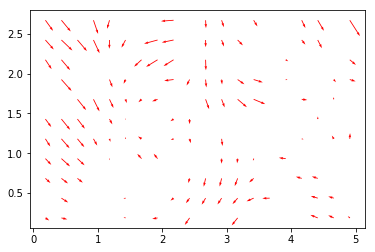

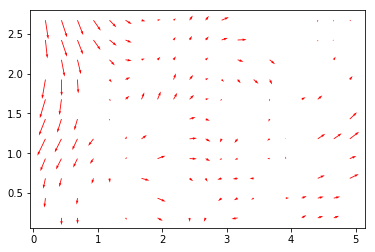

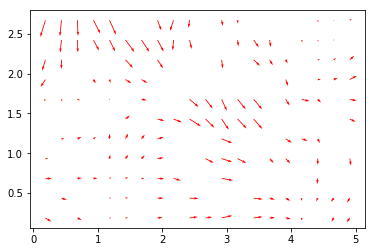

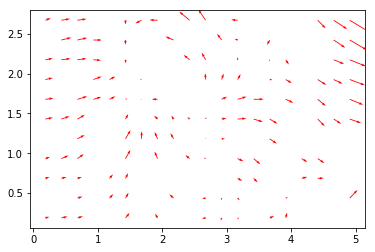

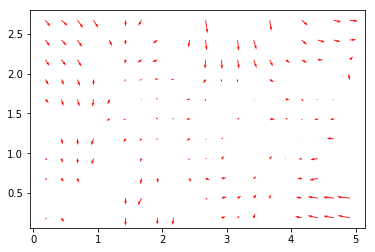

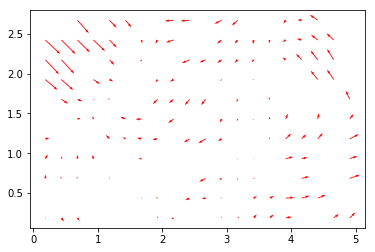

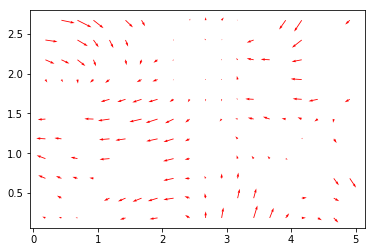

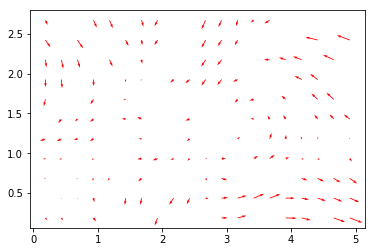

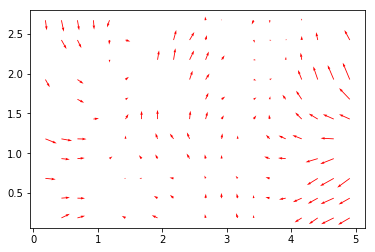

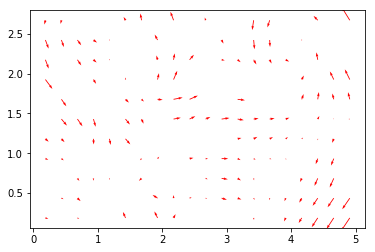

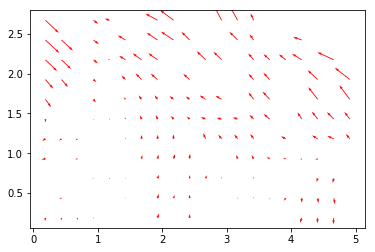

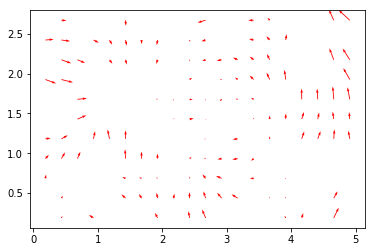

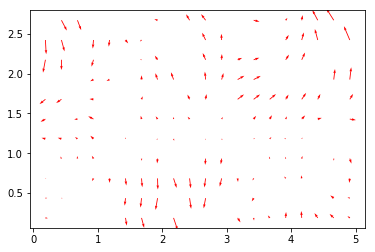

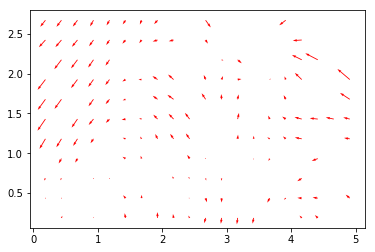

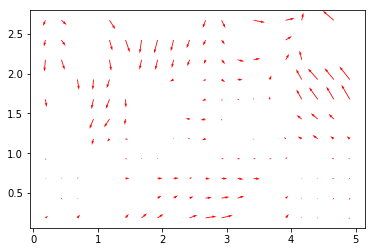

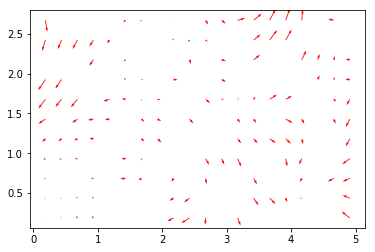

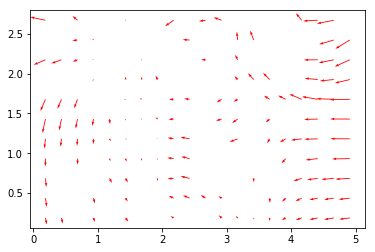

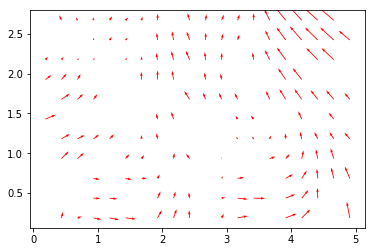

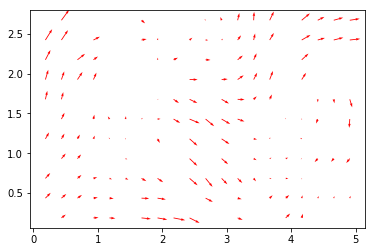

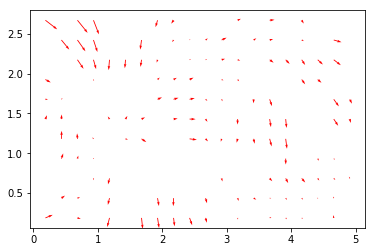

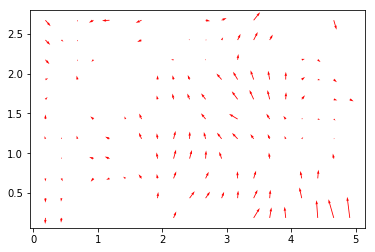

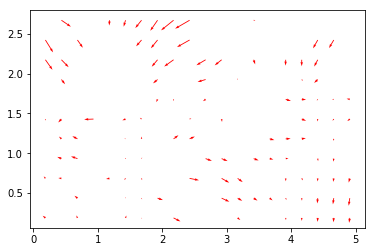

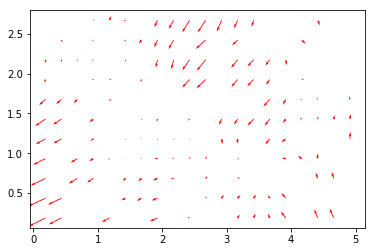

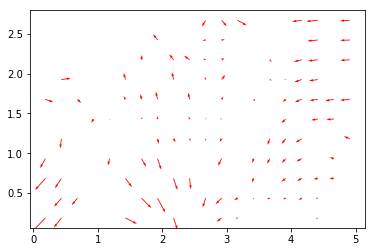

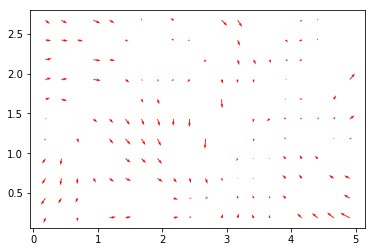

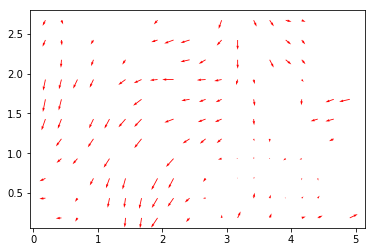

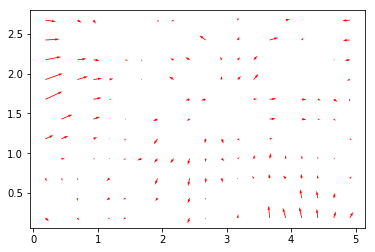

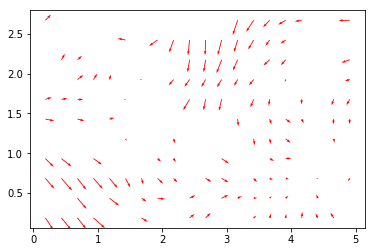

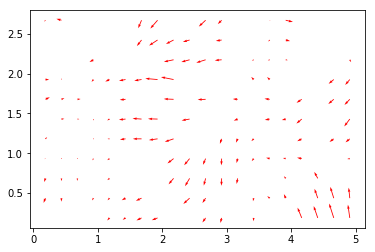

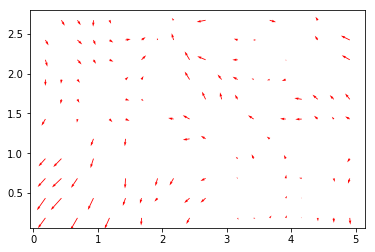

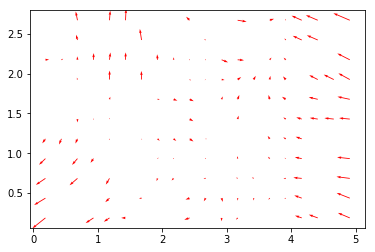

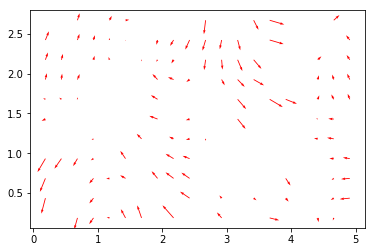

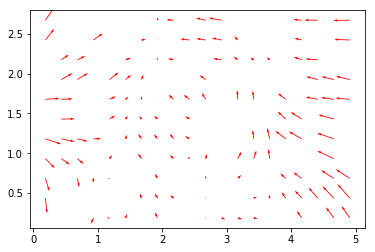

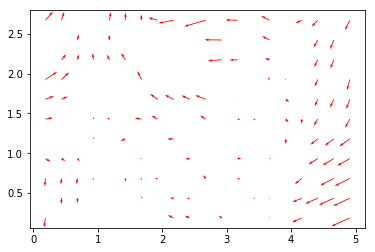

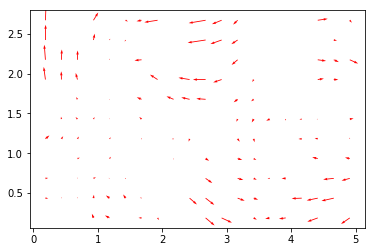

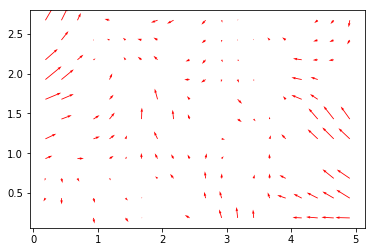

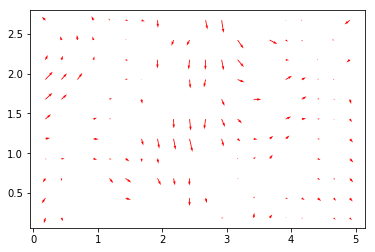

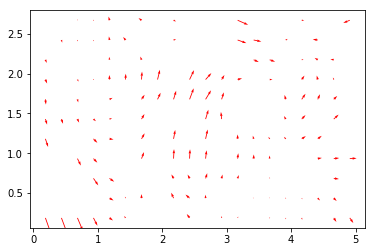

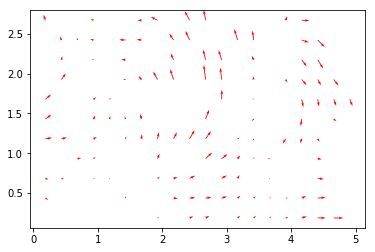

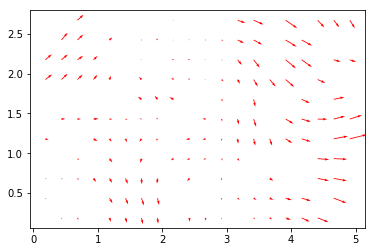

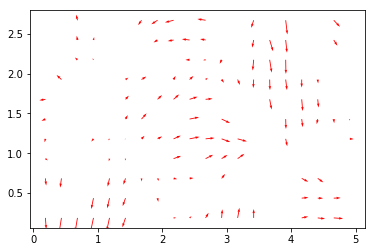

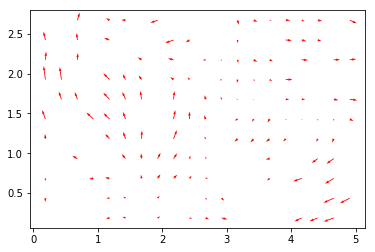

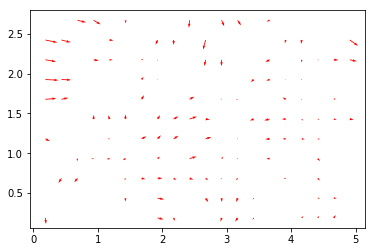

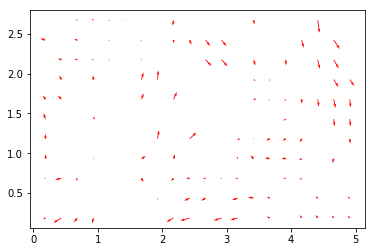

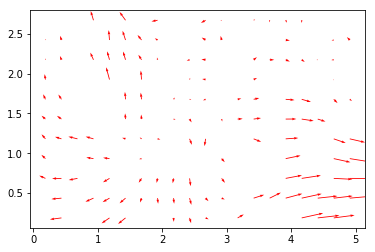

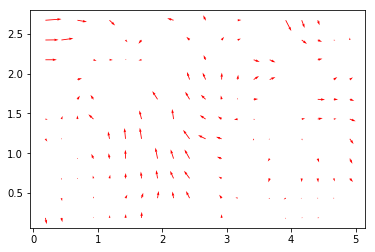

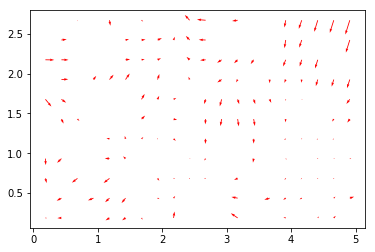

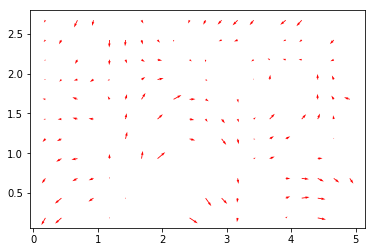

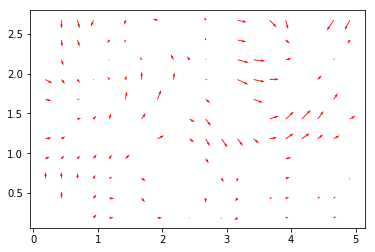

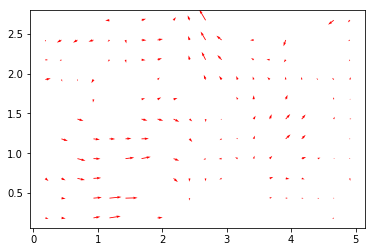

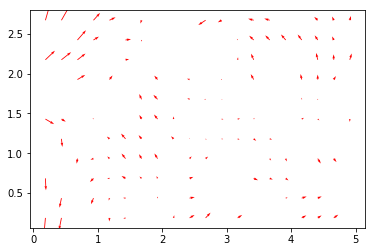

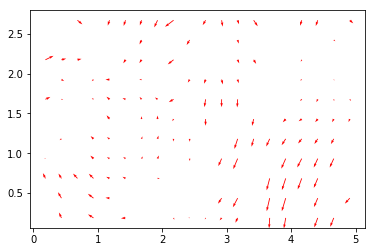

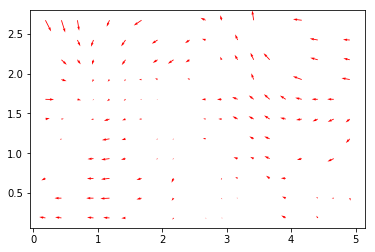

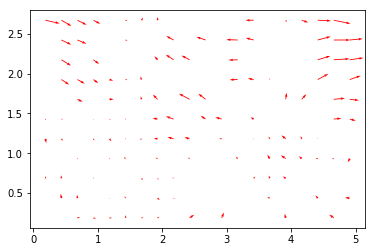

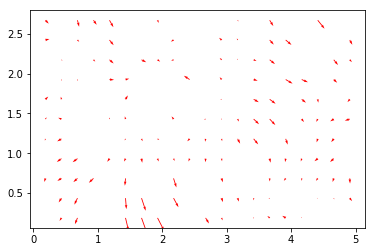

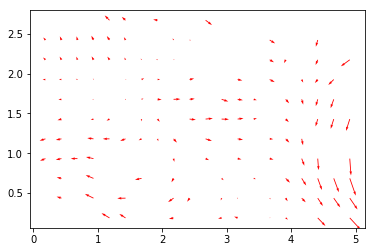

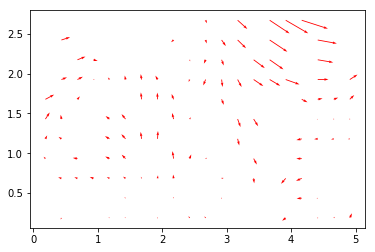

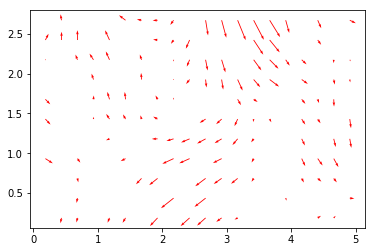

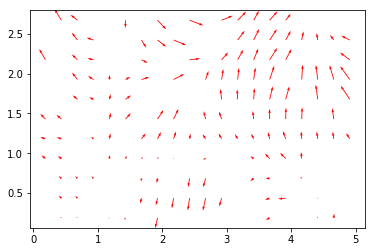

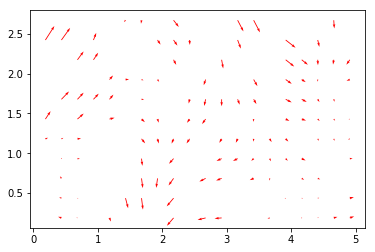

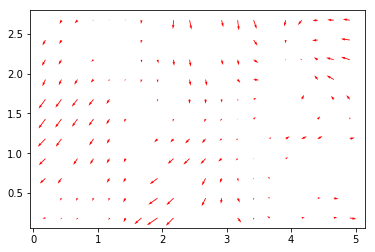

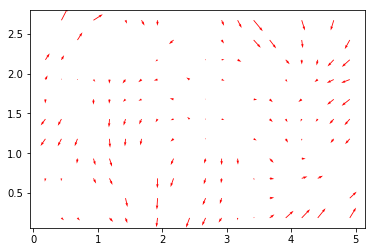

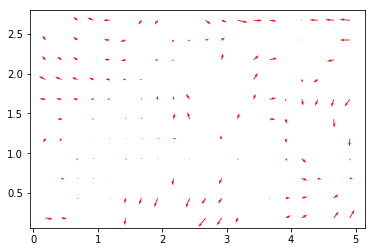

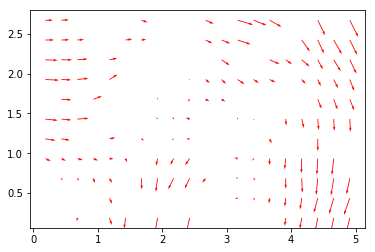

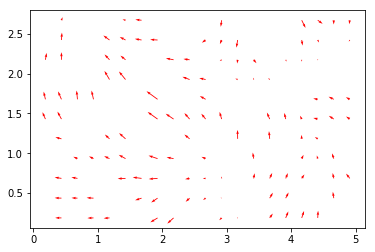

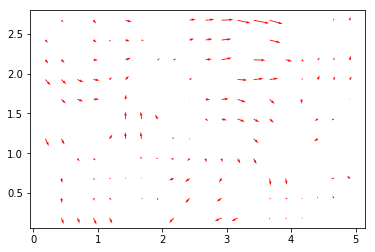

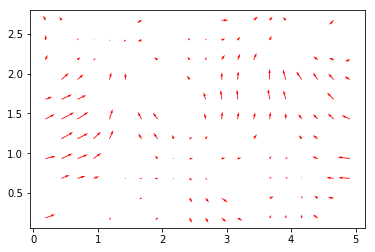

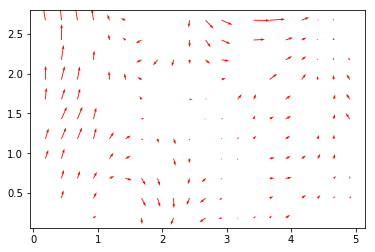

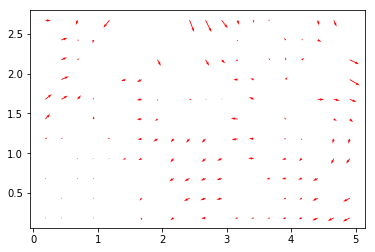

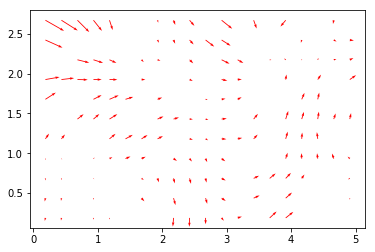

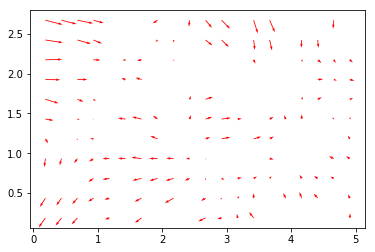

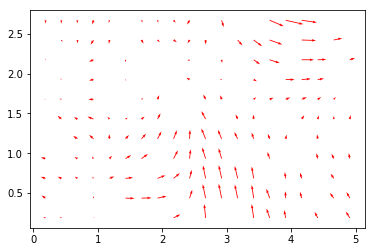

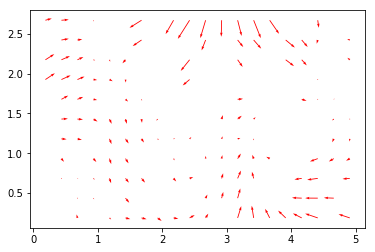

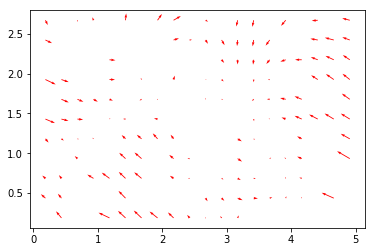

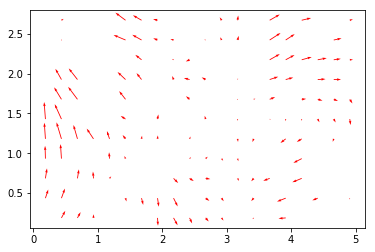

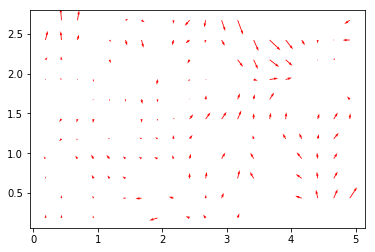

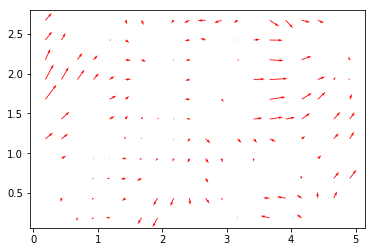

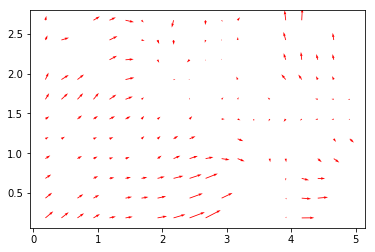

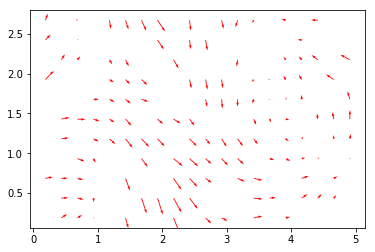

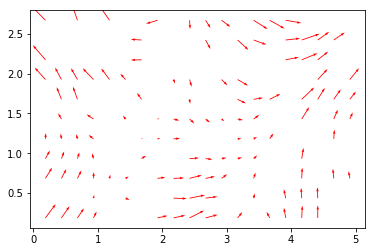

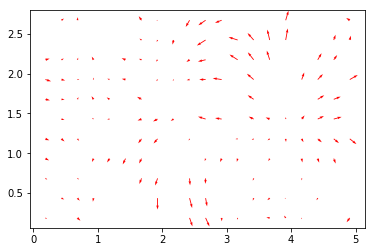

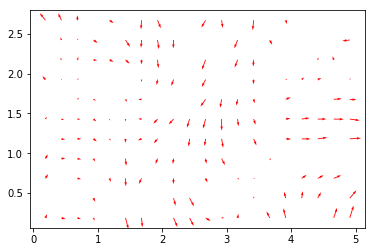

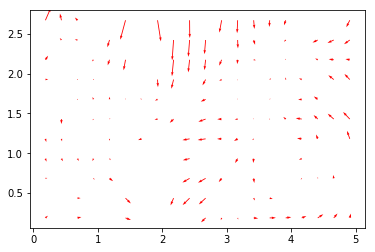

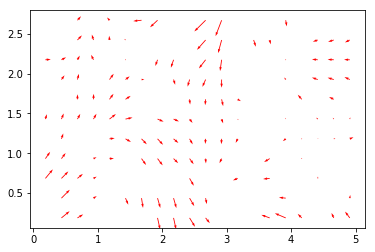

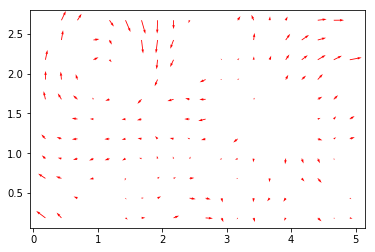

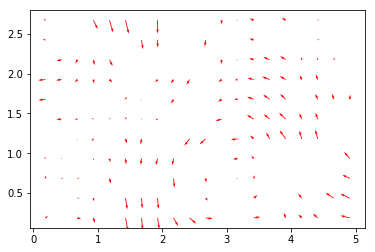

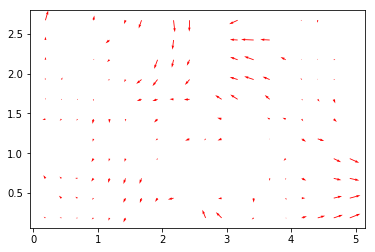

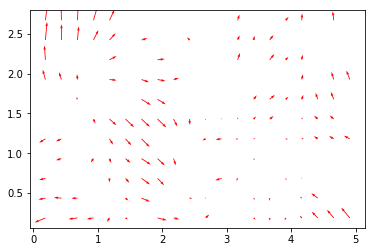

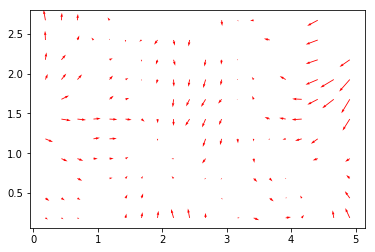

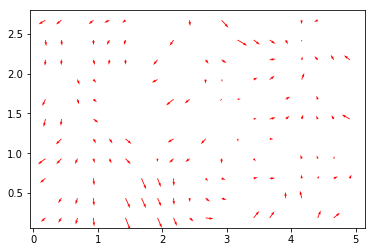

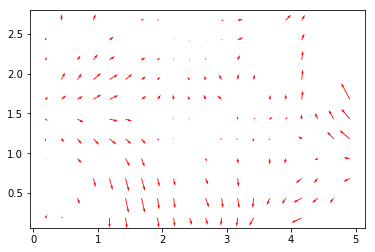

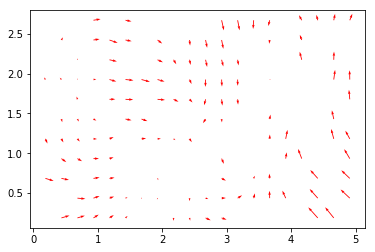

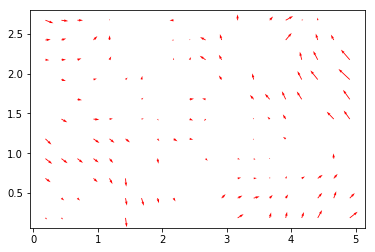

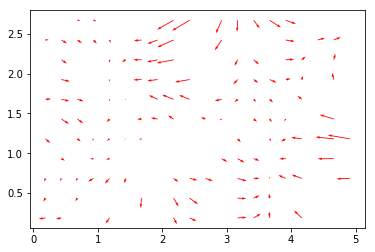

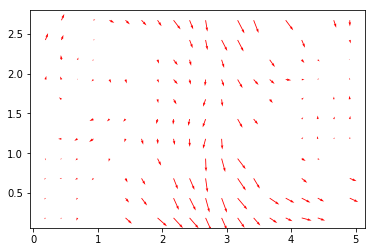

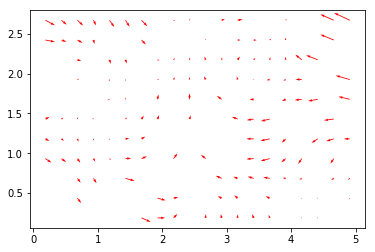

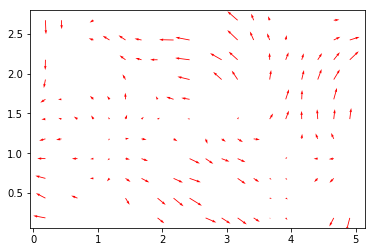

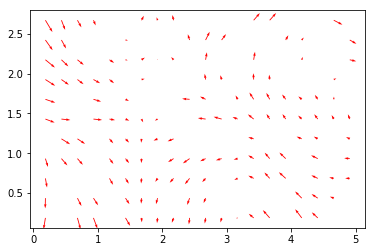

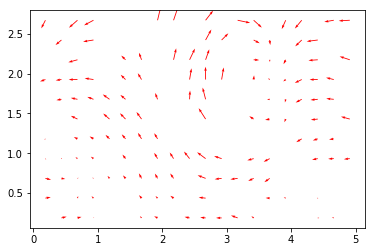

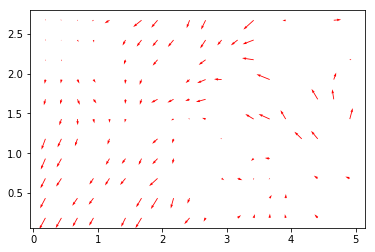

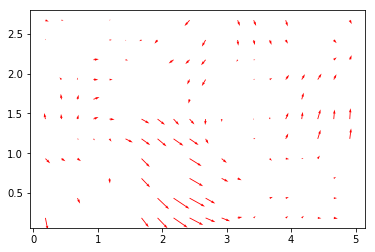

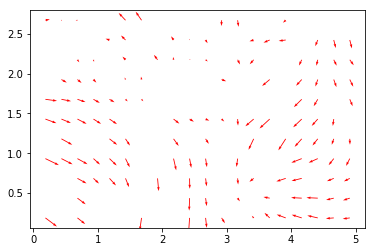

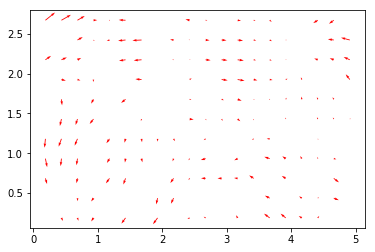

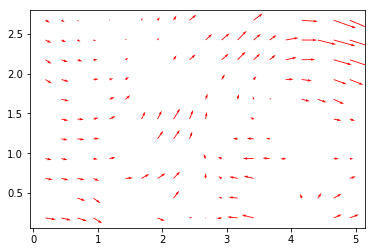

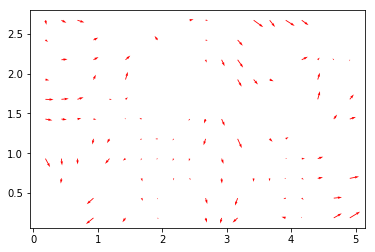

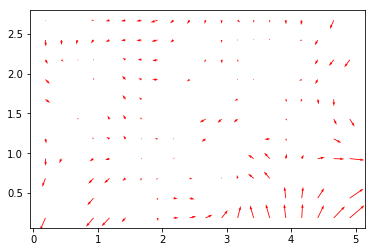

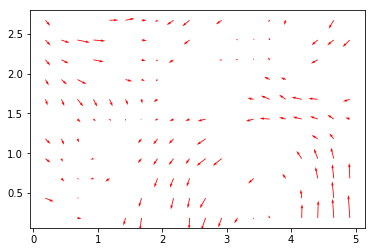

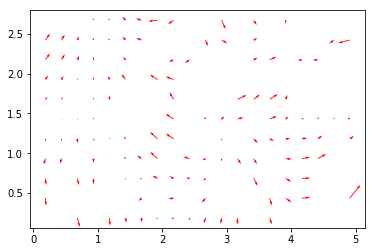

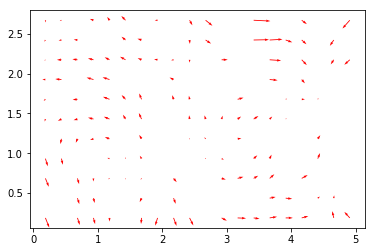

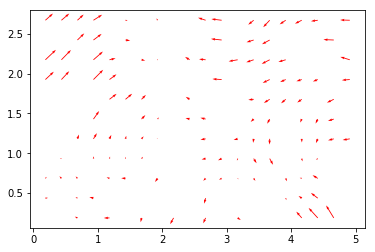

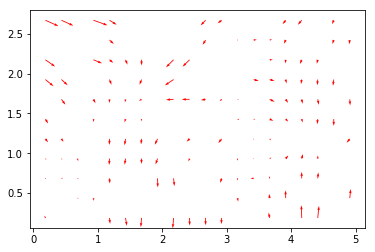

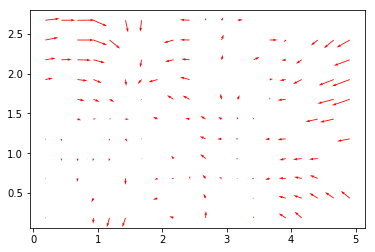

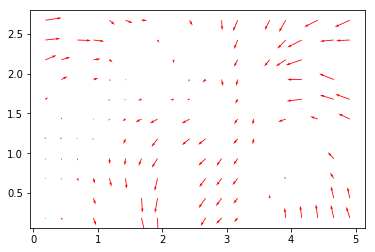

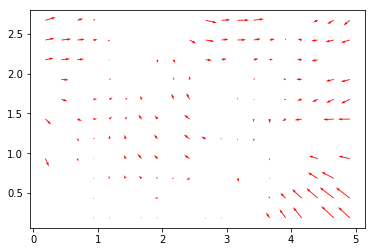

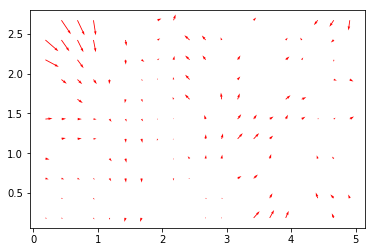

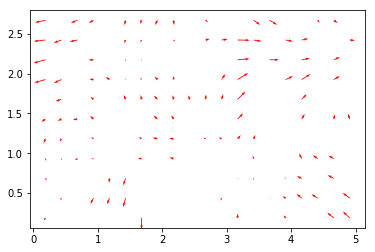

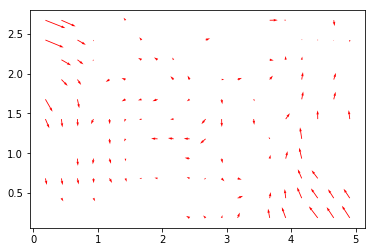

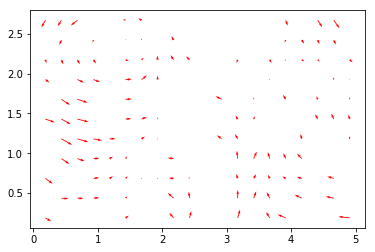

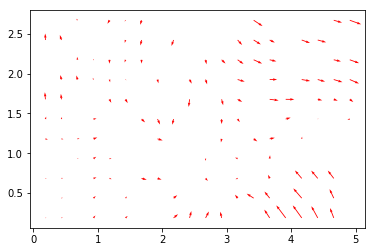

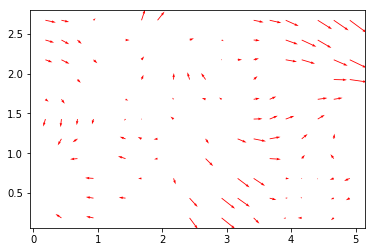

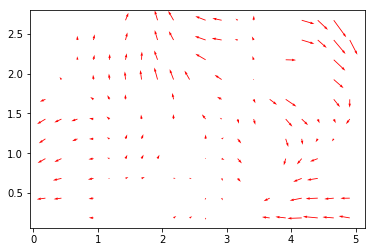

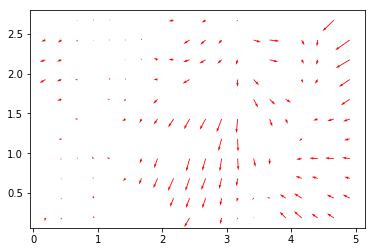

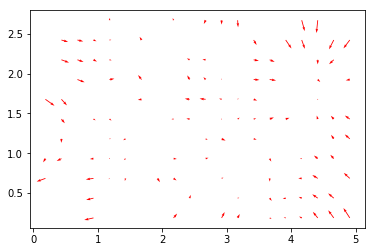

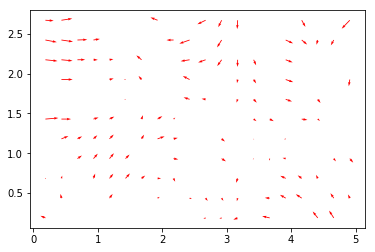

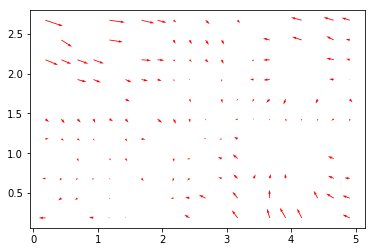

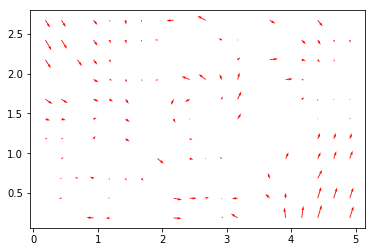

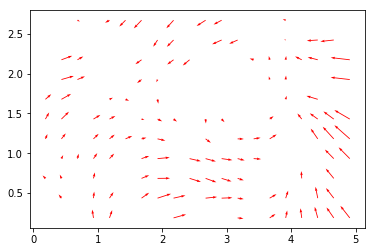

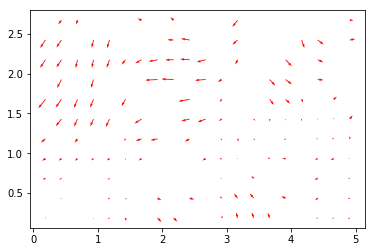

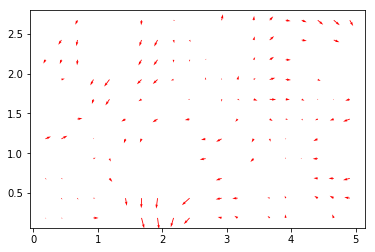

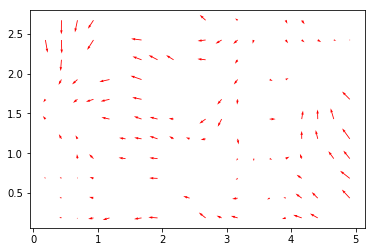

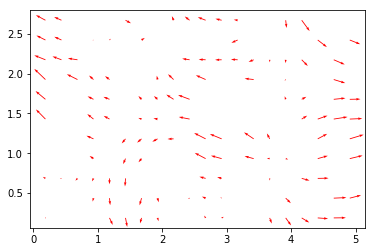

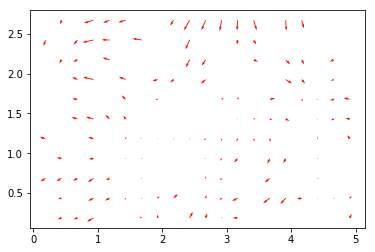

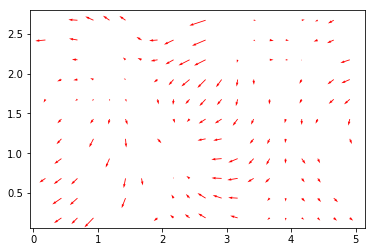

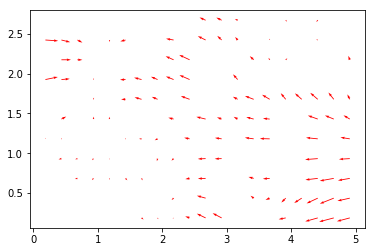

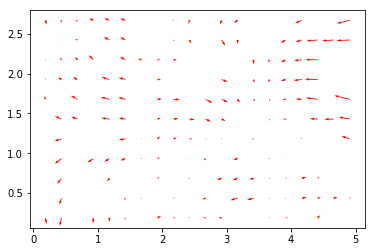

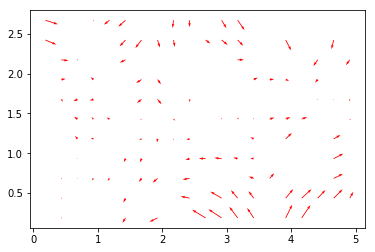

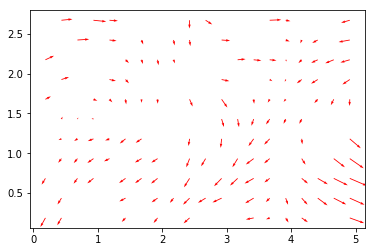

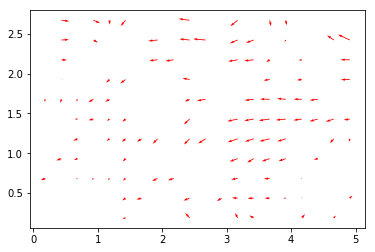

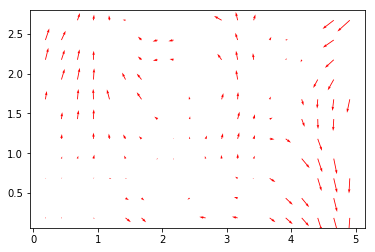

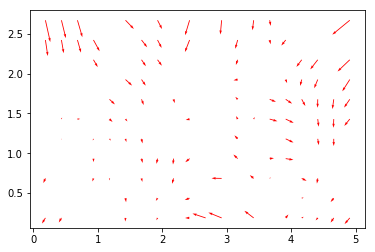

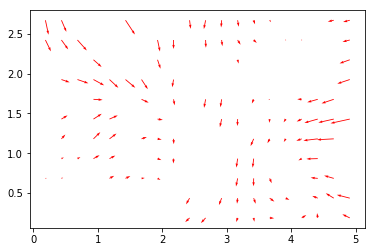

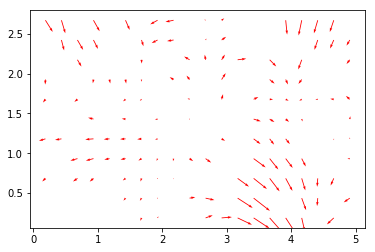

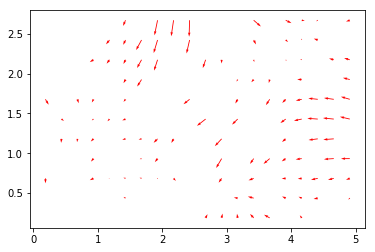

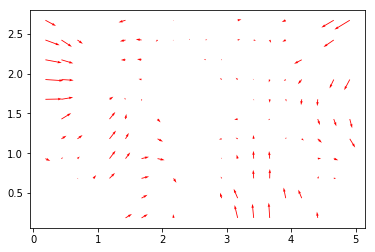

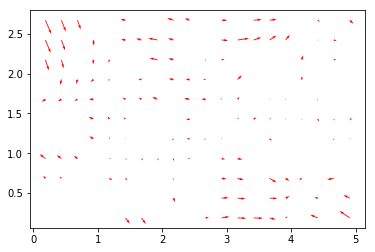

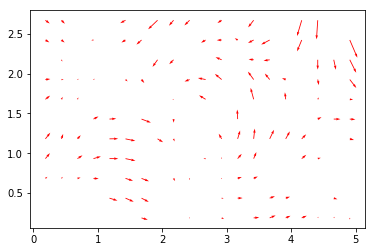

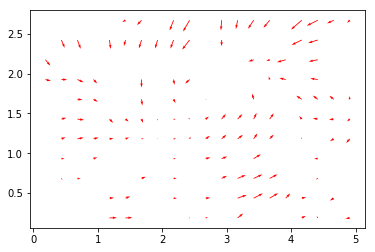

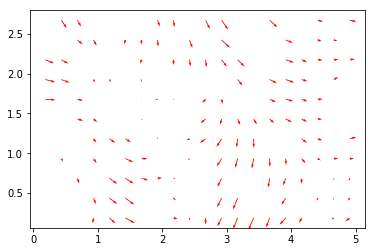

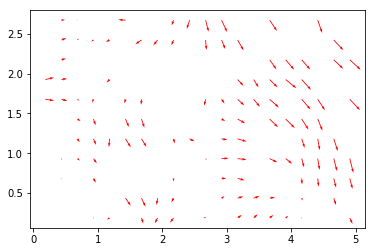

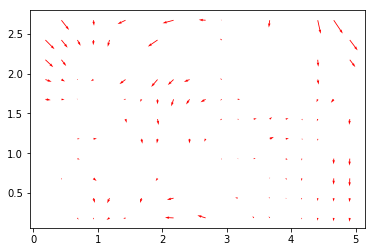

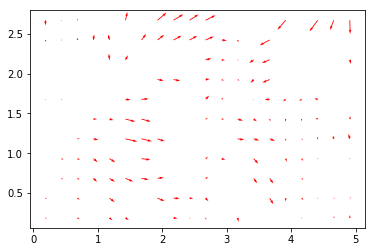

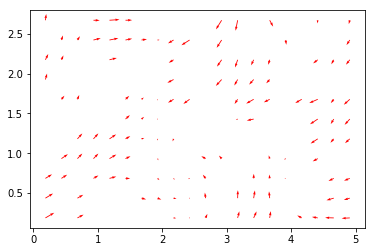

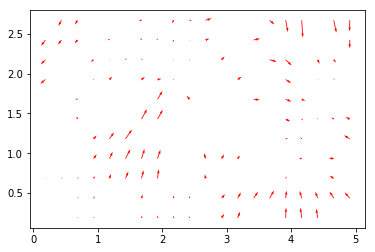

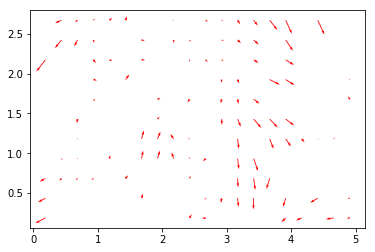

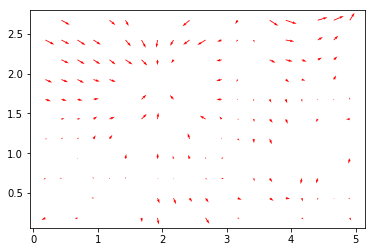

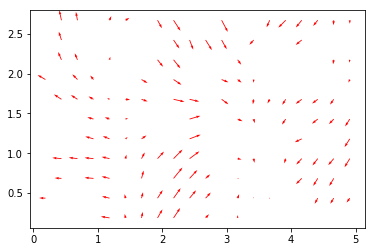

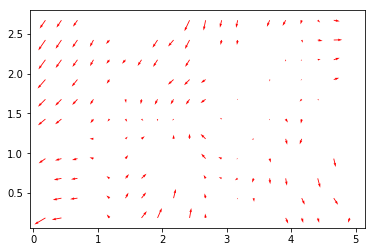

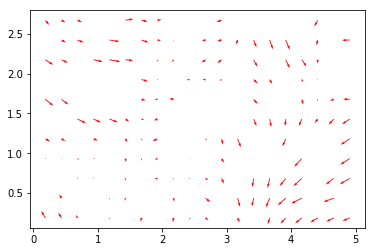

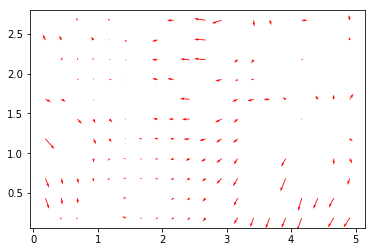

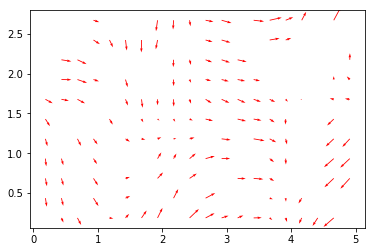

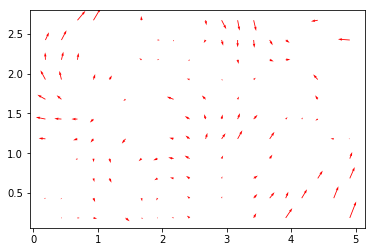

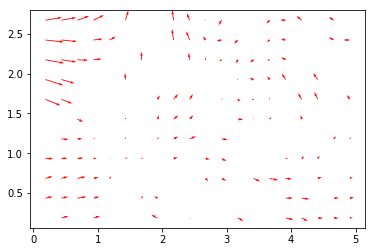

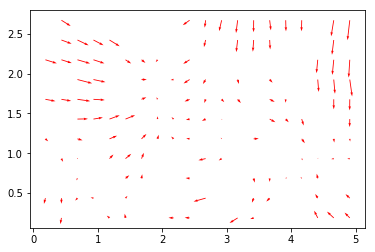

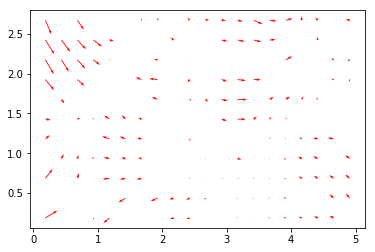

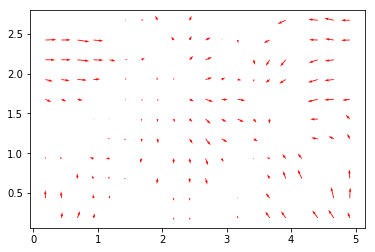

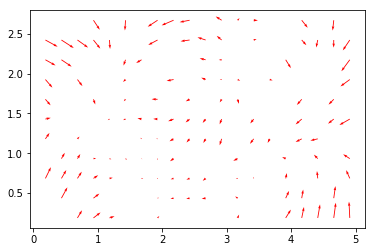

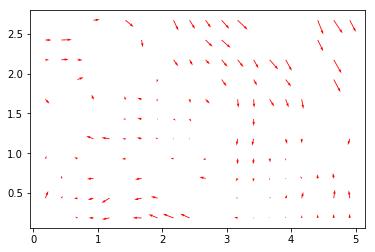

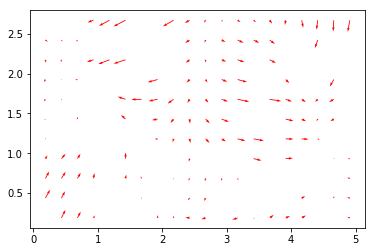

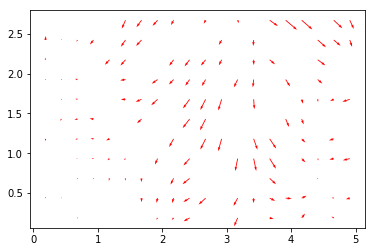

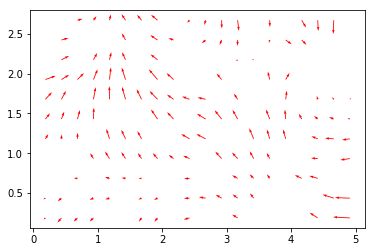

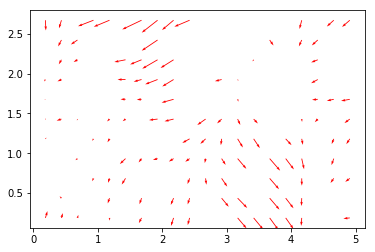

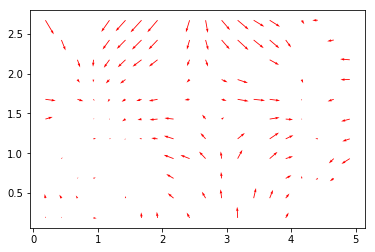

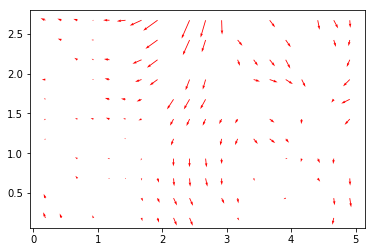

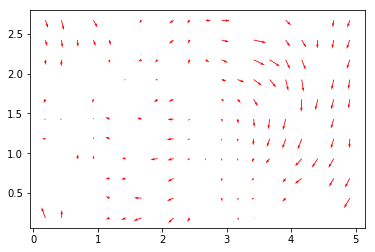

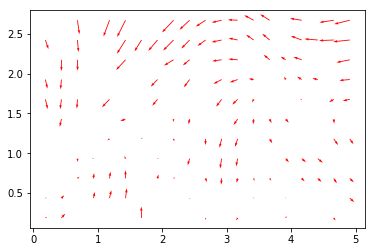

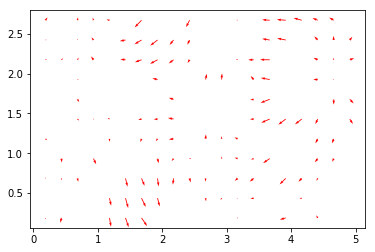

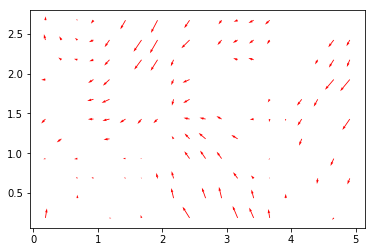

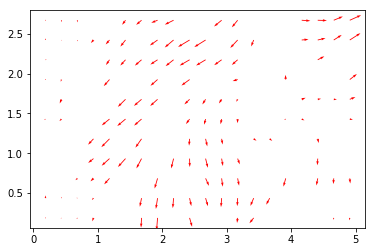

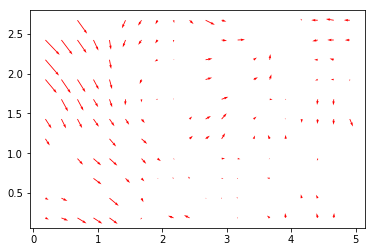

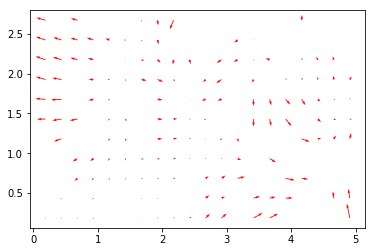

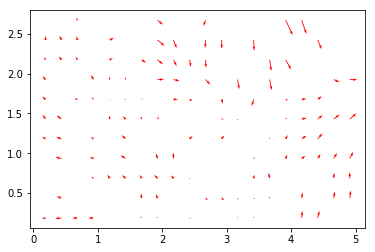

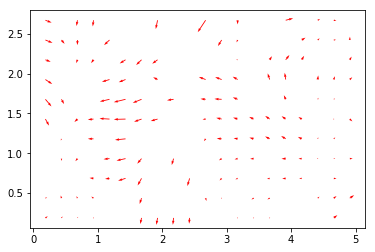

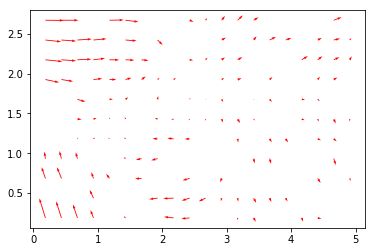

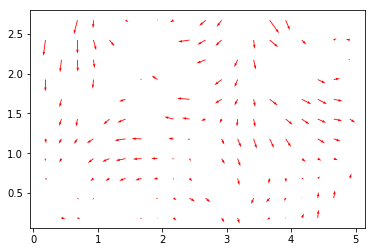

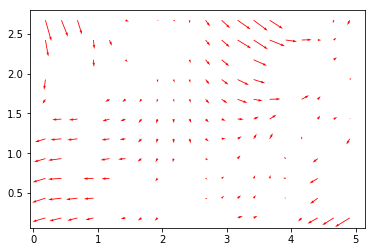

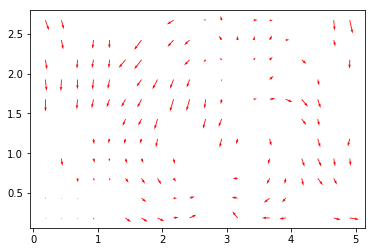

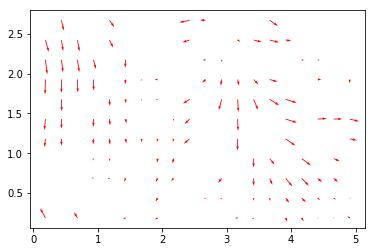

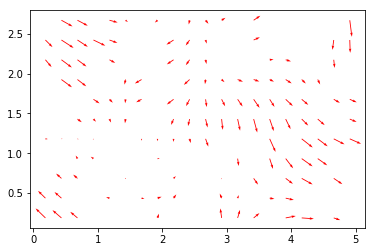

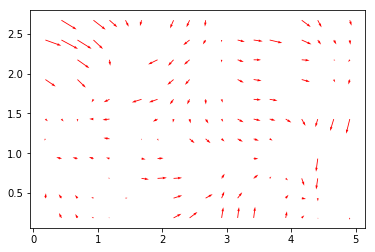

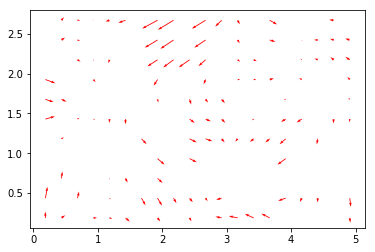

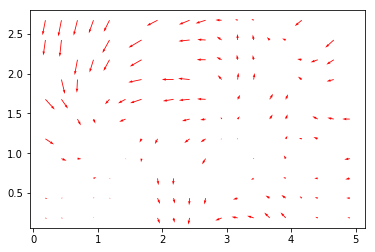

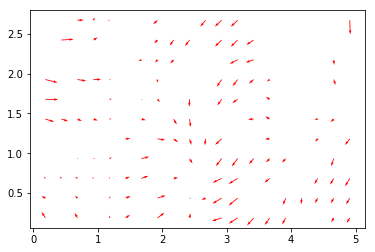

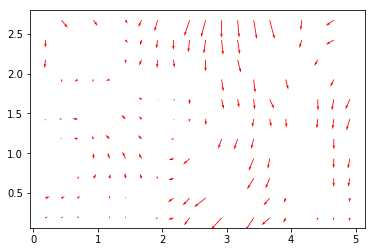

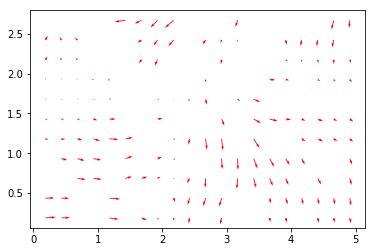

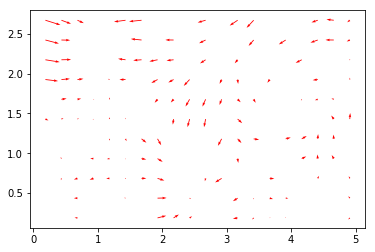

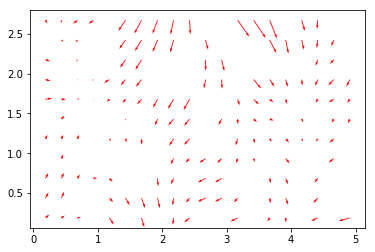

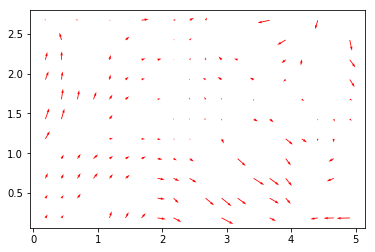

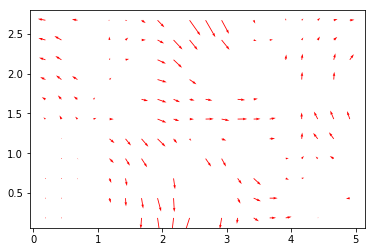

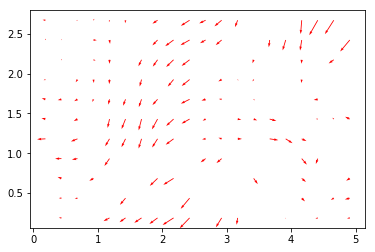

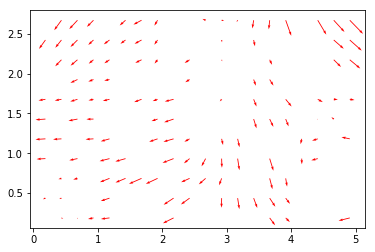

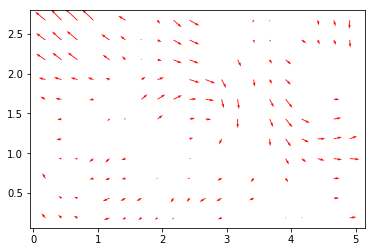

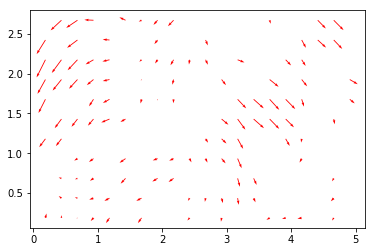

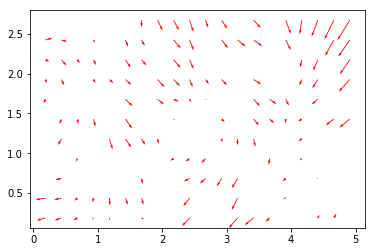

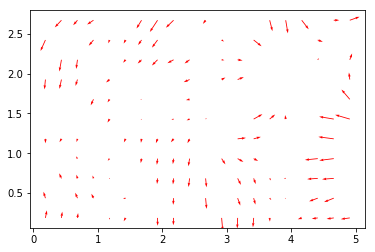

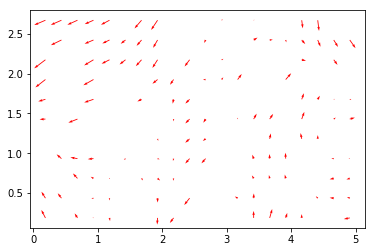

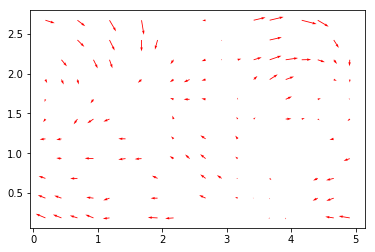

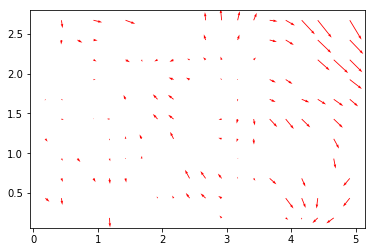

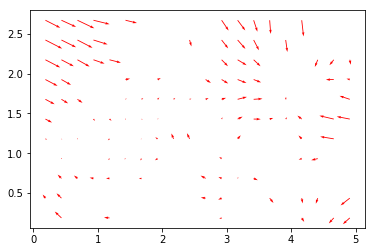

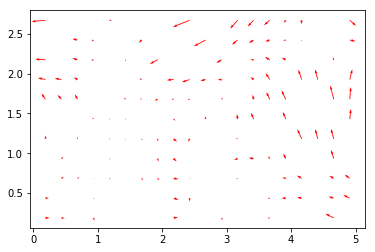

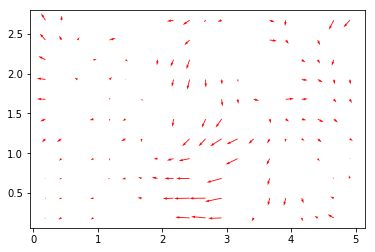

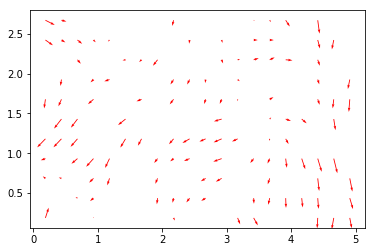

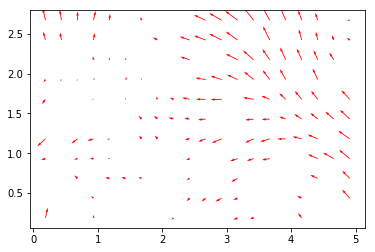

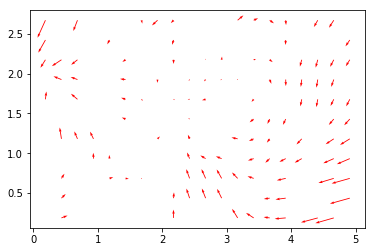

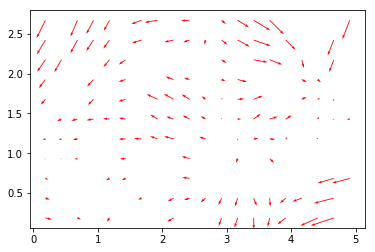

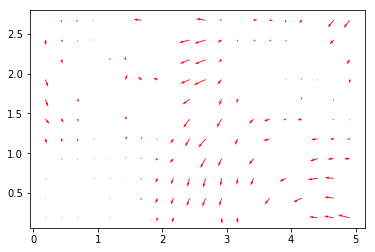

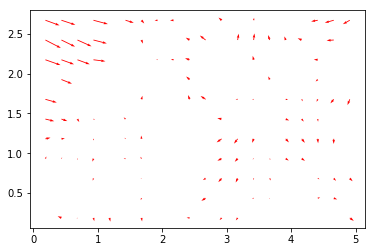

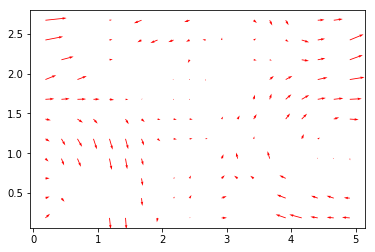

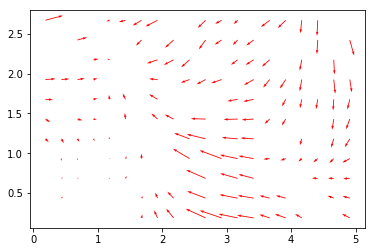

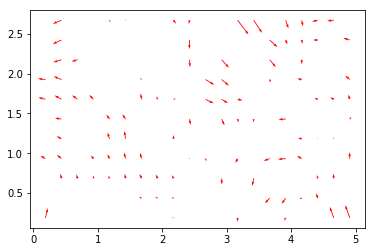

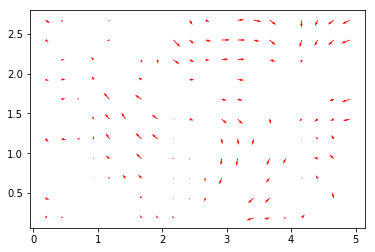

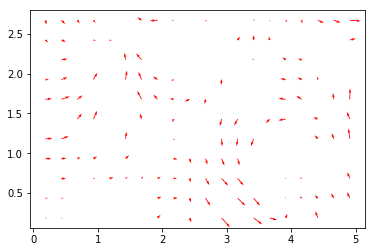

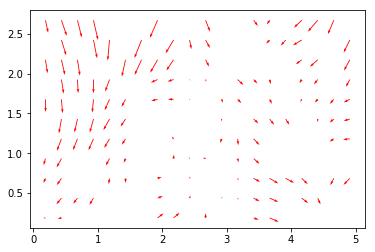

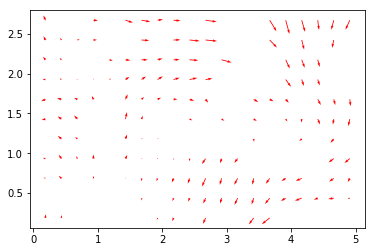

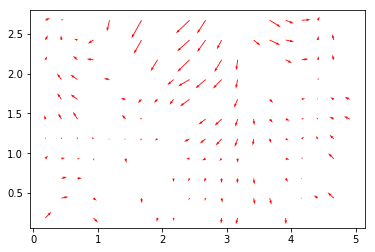

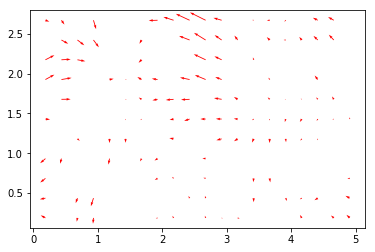

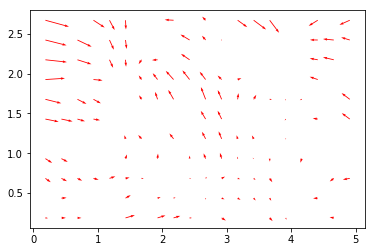

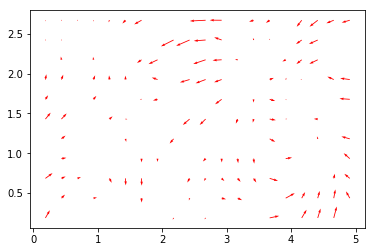

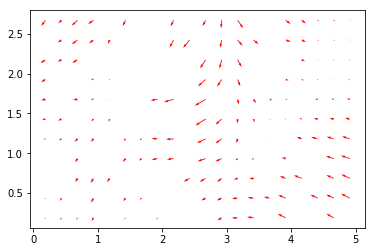

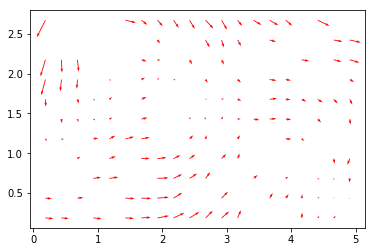

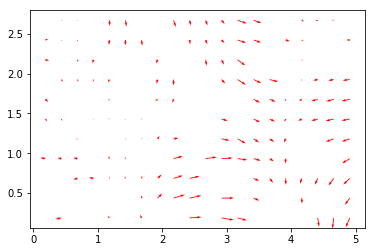

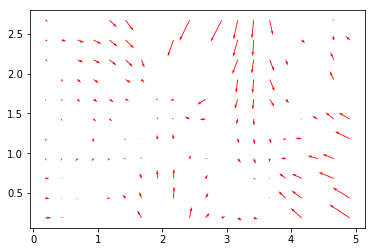

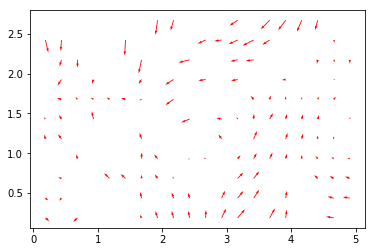

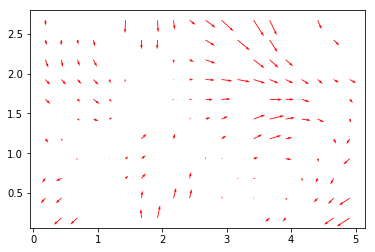

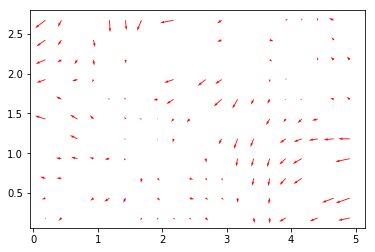

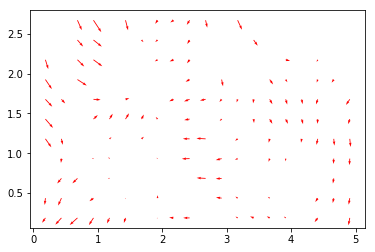

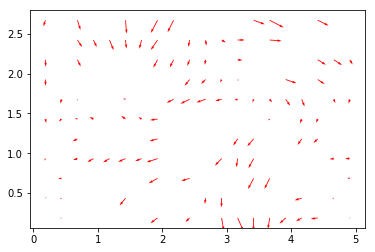

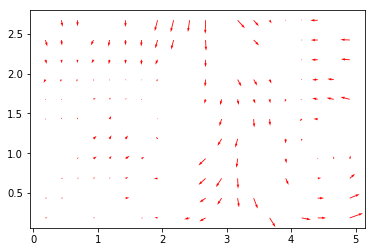

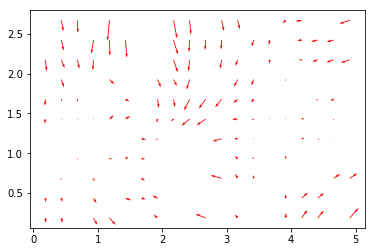

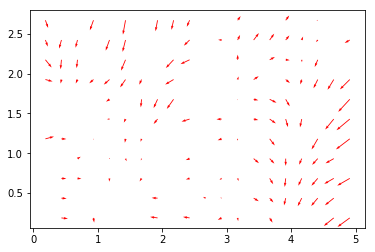

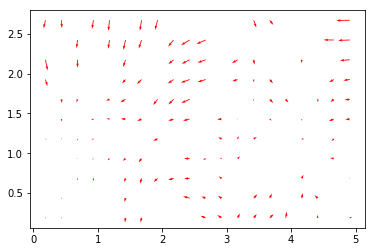

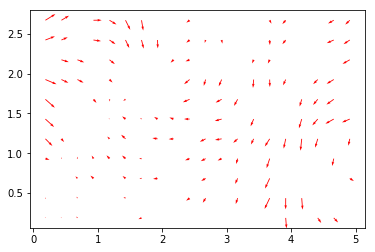

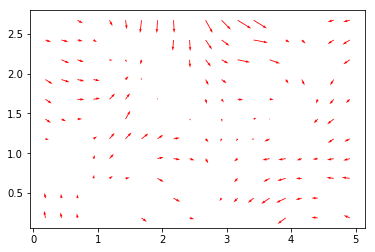

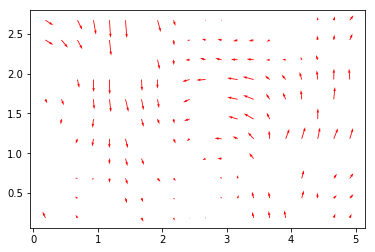

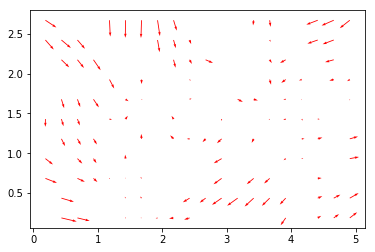

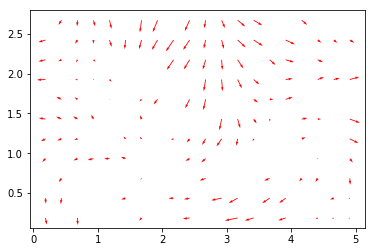

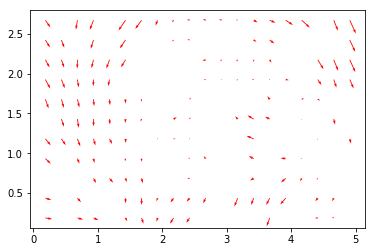

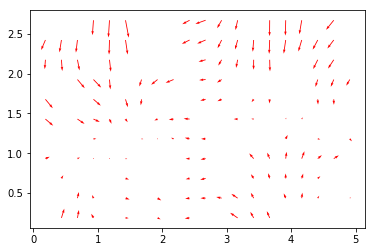

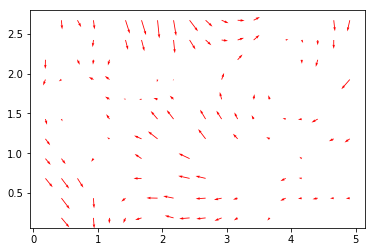

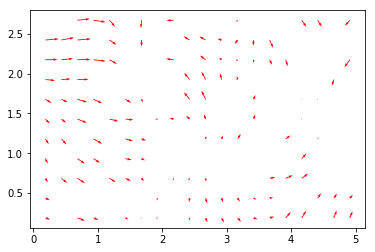

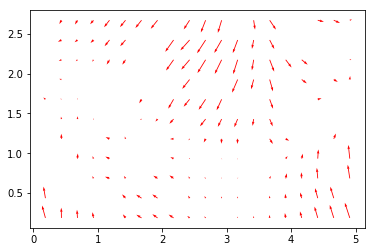

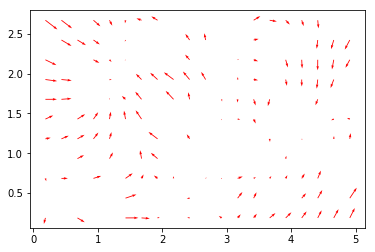

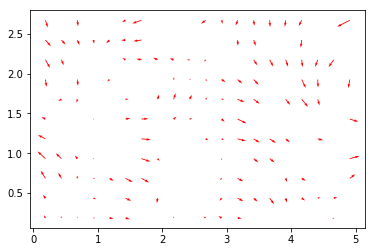

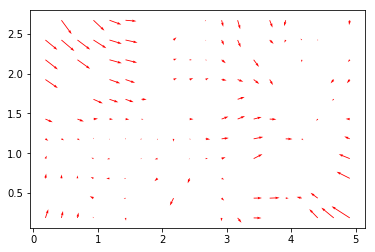

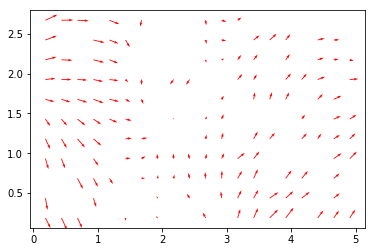

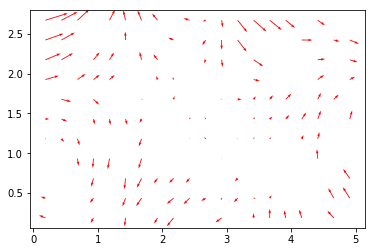

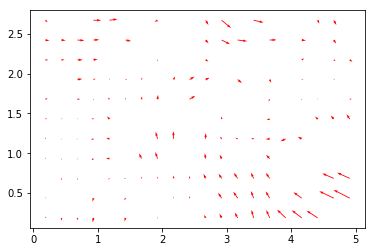

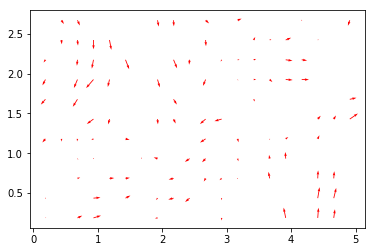

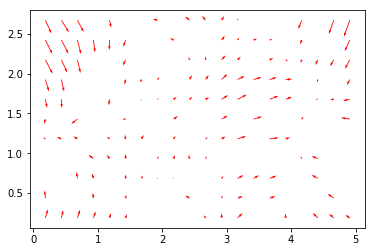

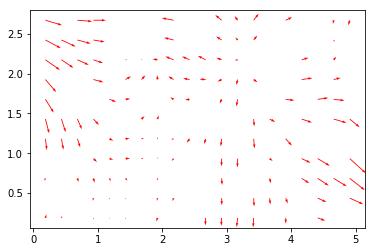

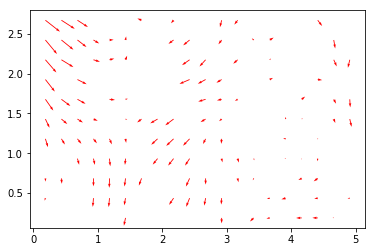

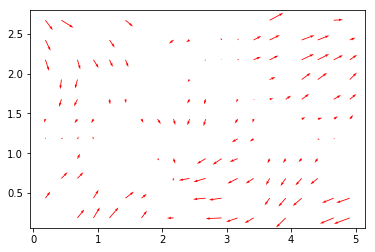

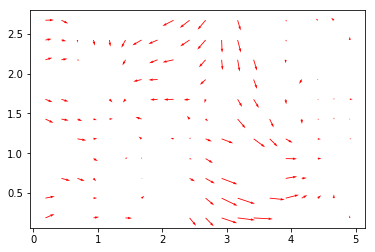

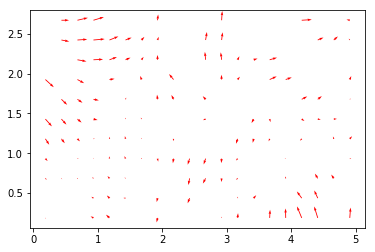

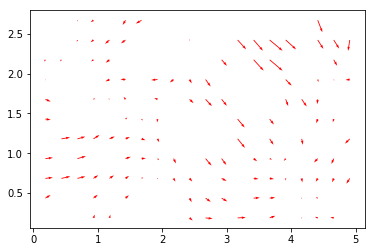

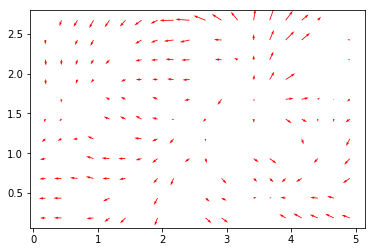

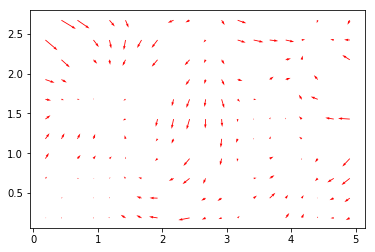

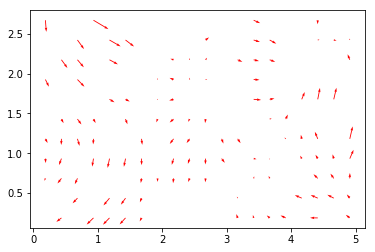

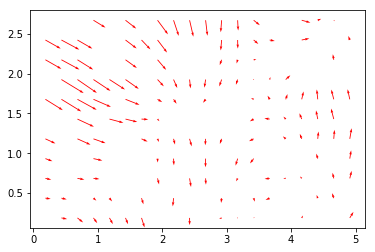

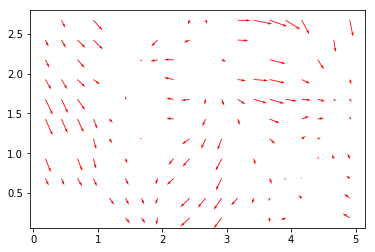

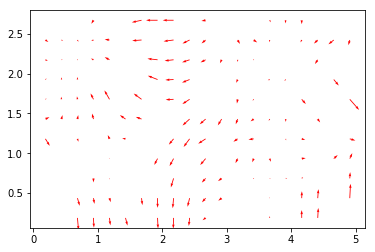

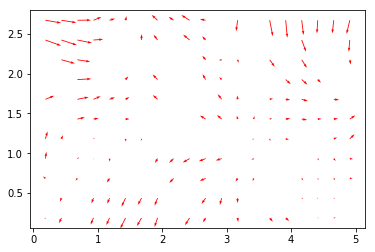

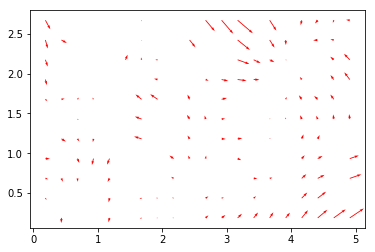

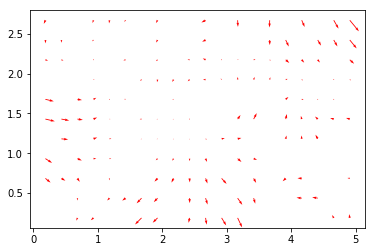

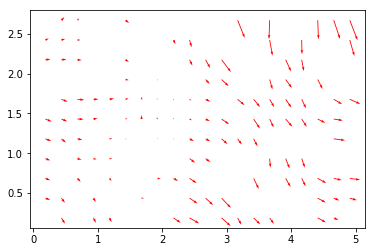

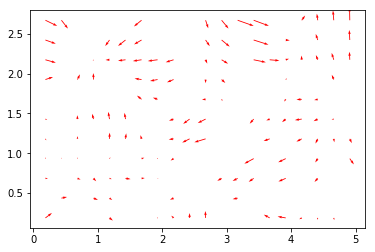

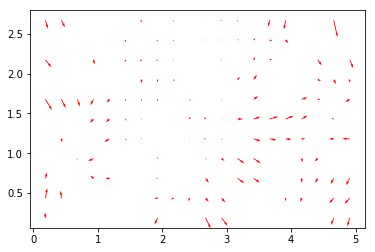

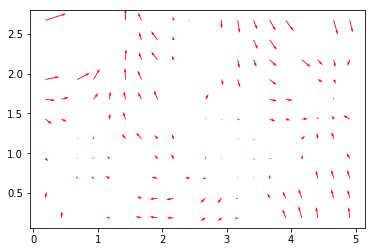

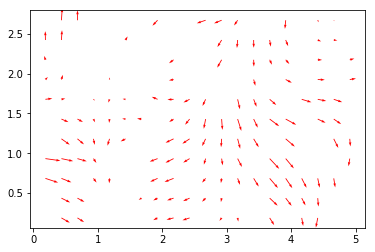

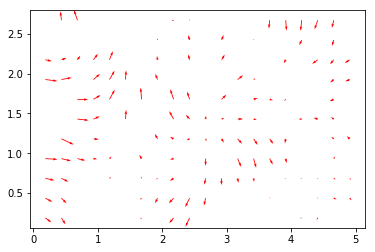

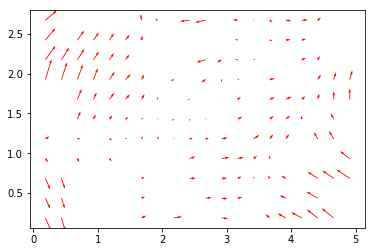

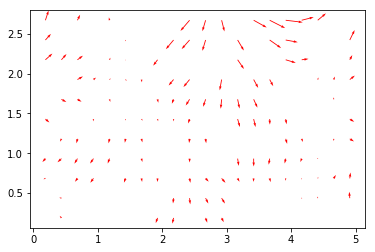

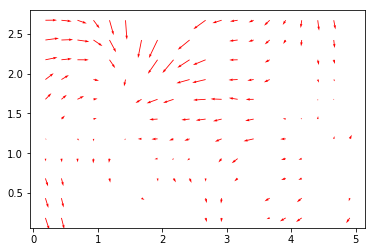

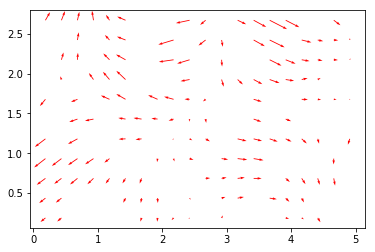

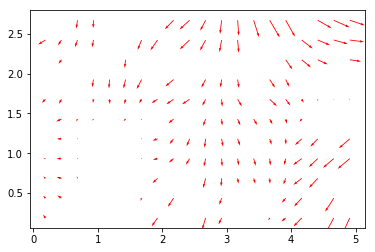

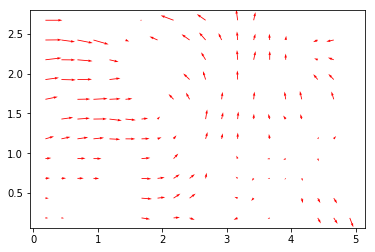

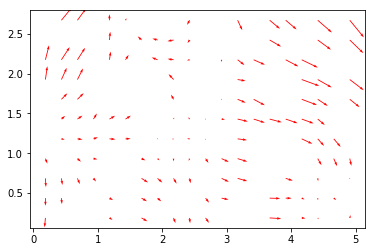

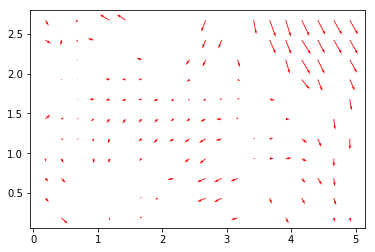

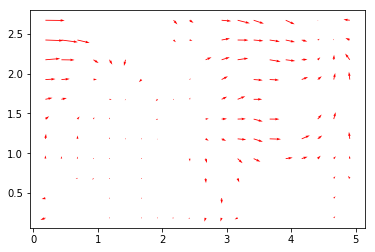

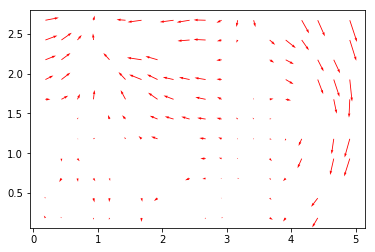

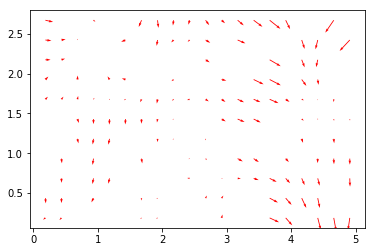

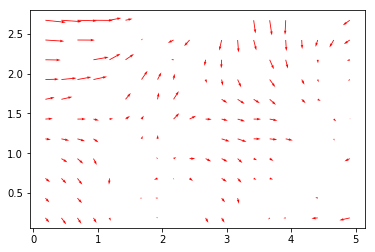

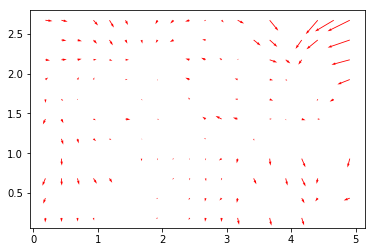

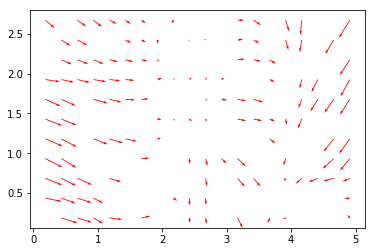

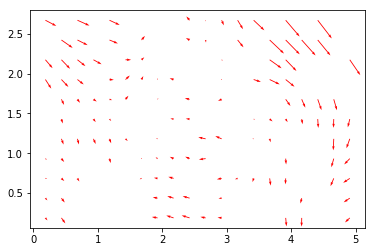

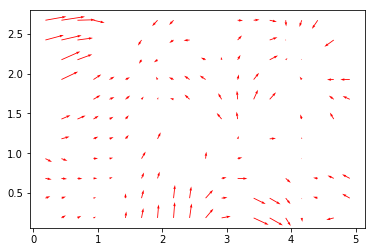

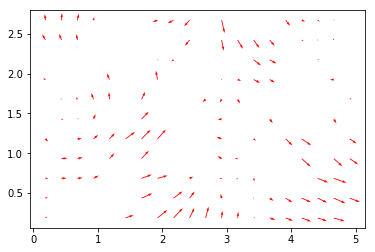

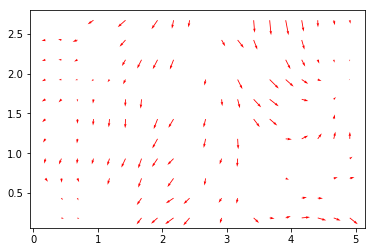

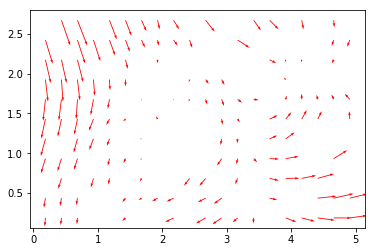

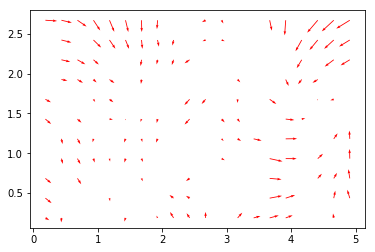

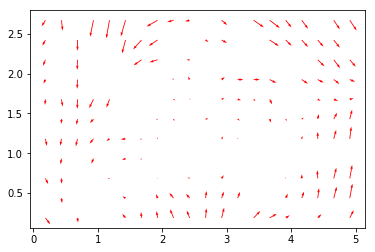

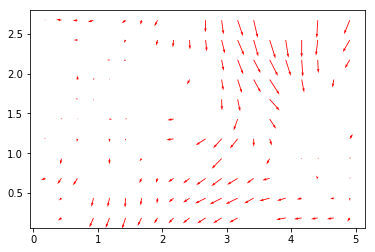

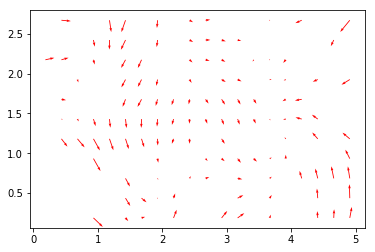

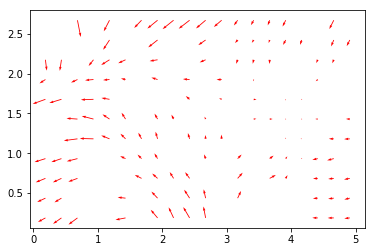

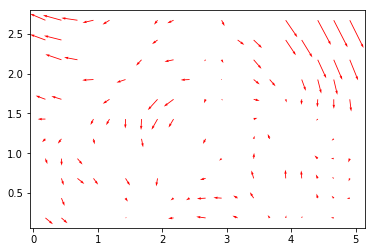

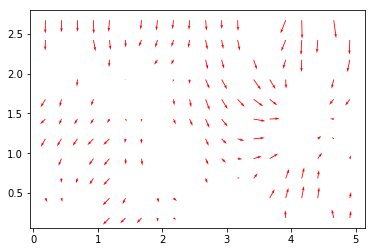

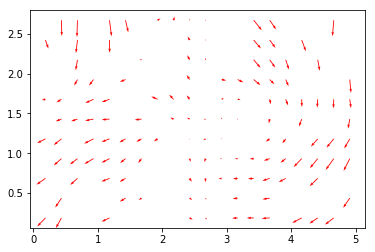

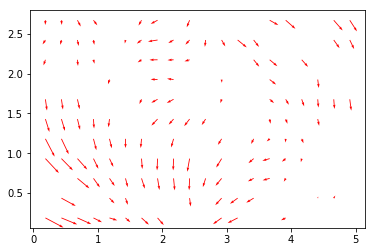

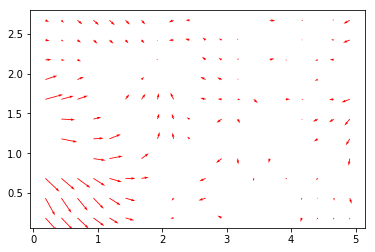

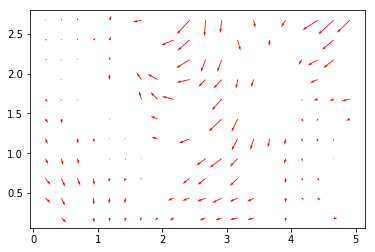

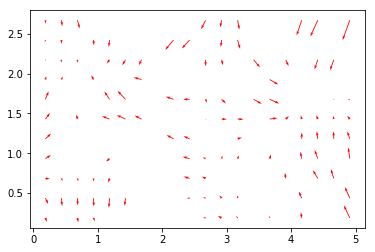

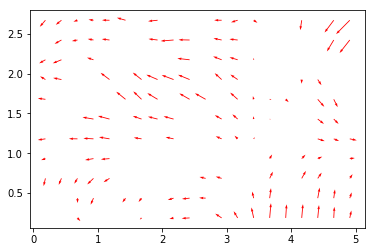

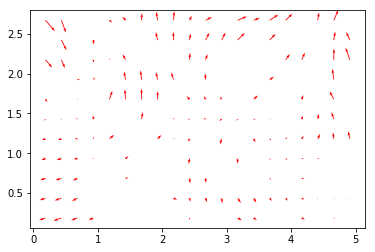

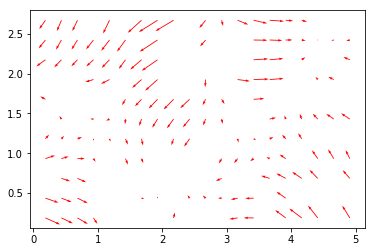

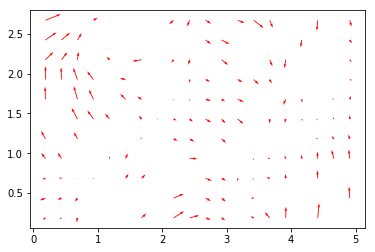

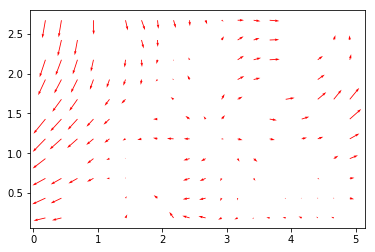

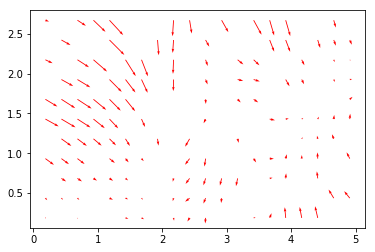

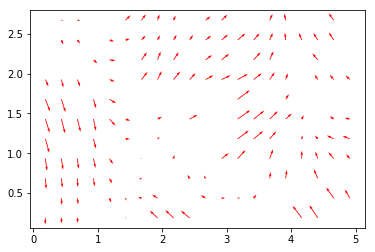

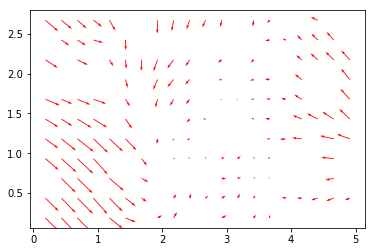

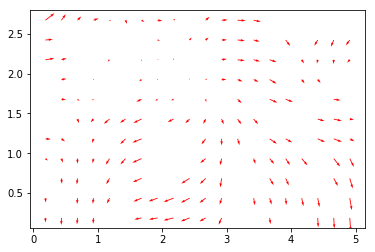

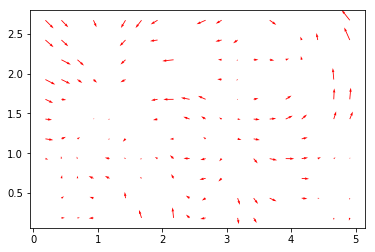

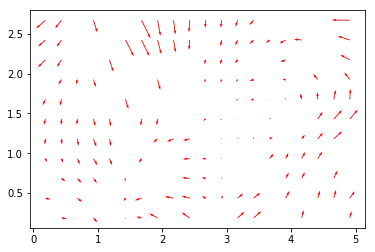

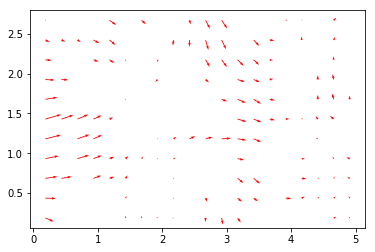

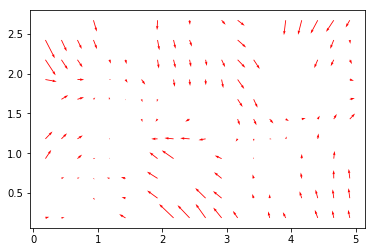

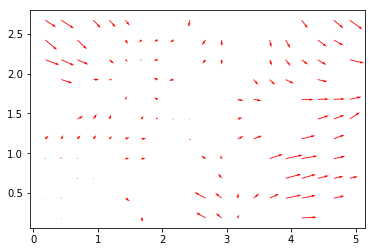

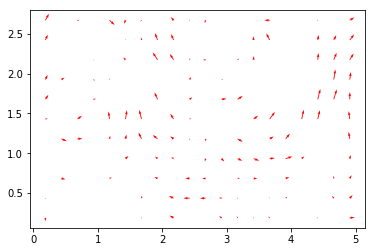

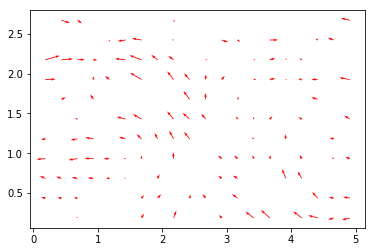

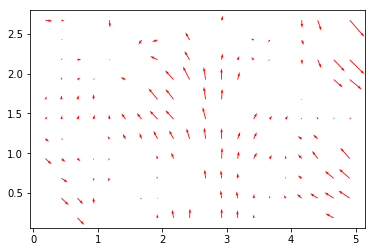

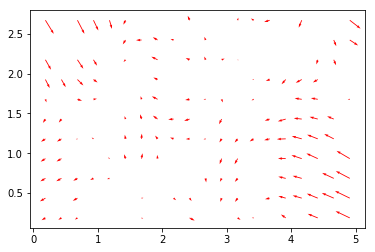

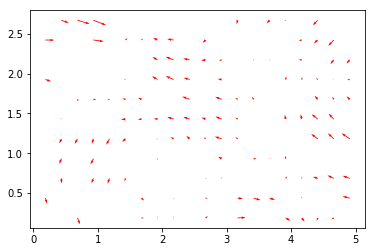

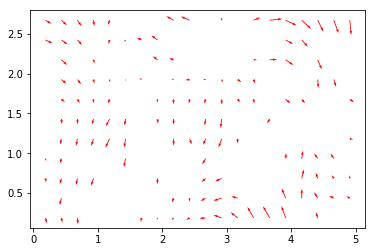

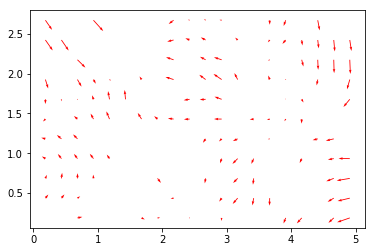

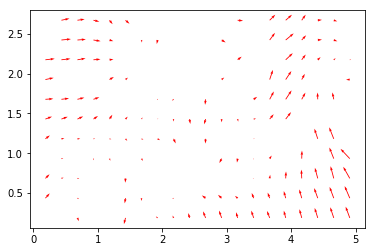

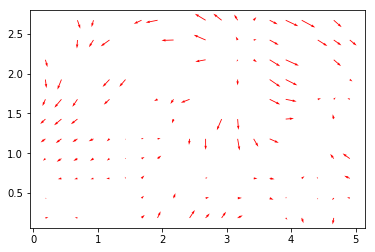

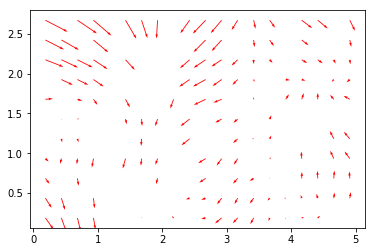

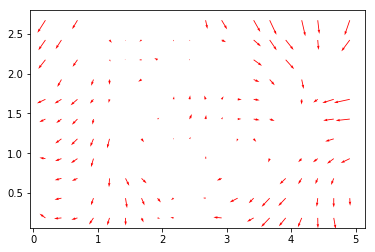

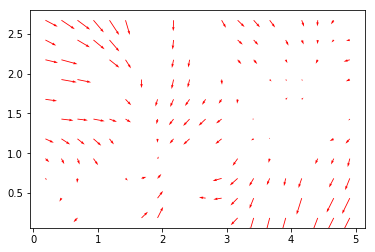

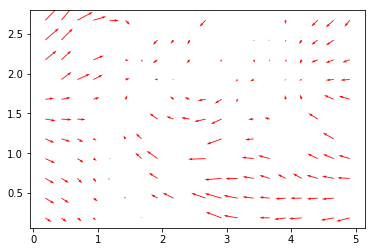

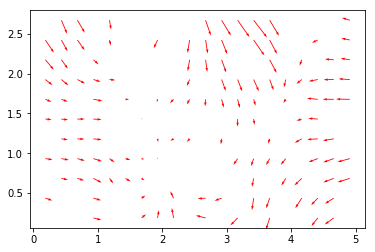

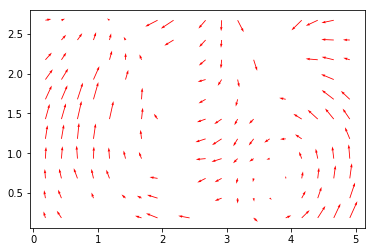

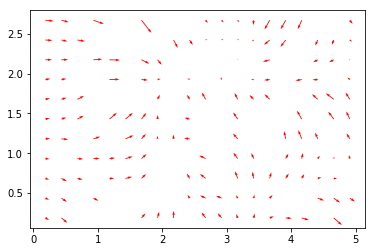

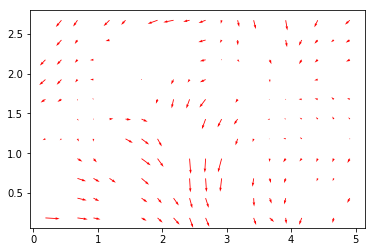

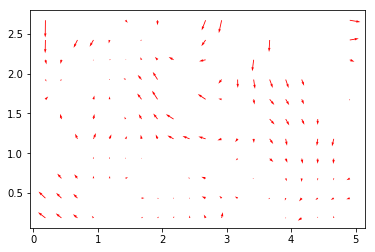

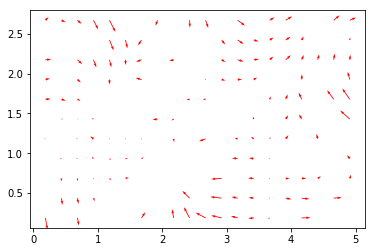

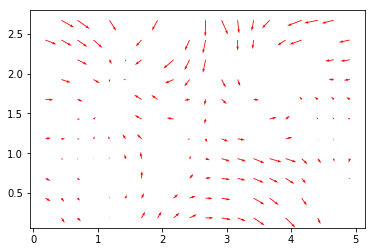

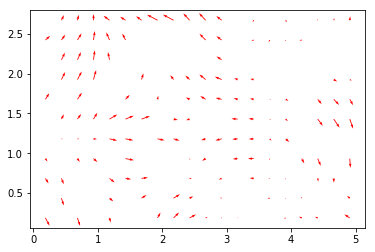

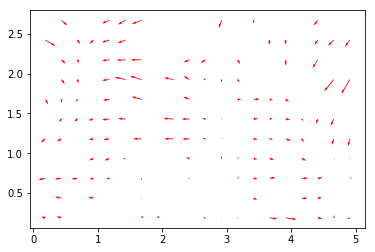

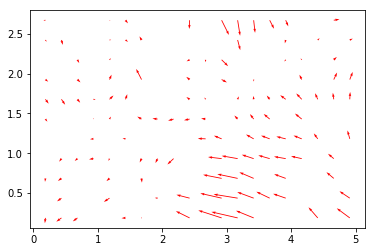

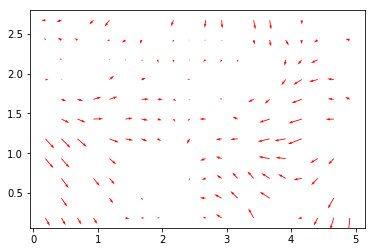

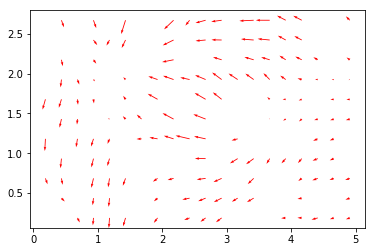

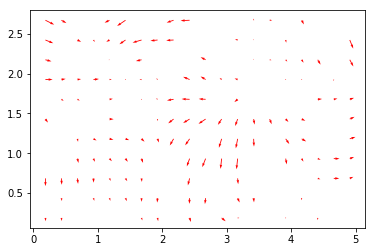

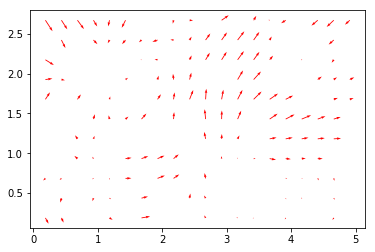

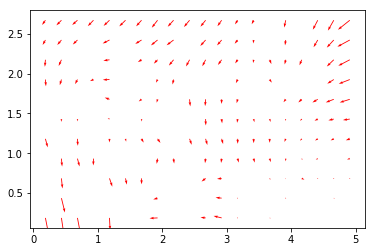

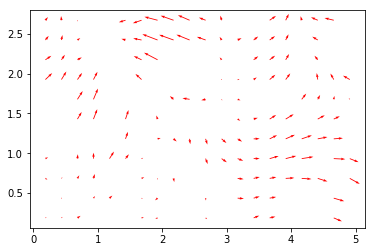

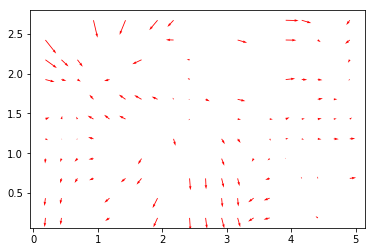

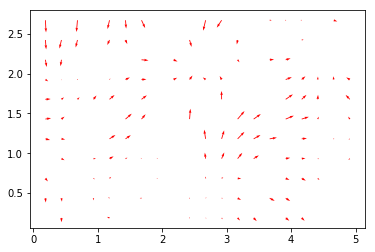

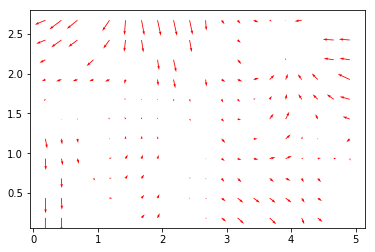

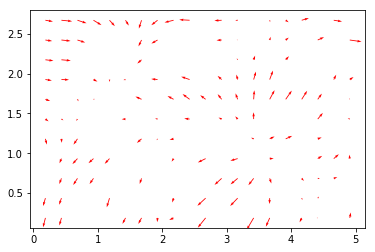

In [223]:
# Param 1: history of frames, param 2: threshold value, param 3: shadow-detection
bgSub = cv2.createBackgroundSubtractorMOG2(10, 10, False)

frame_counter = 0
frame_array = []

while(cap.isOpened() == True):
    # Read frames of the video
    ret, frame = cap.read()
    frame_th = bgSub.apply(frame)
    if ret == True:
        frame_th = imutils.resize(frame_th, width = 500)
        frame = imutils.resize(frame, width = 500)
        frame_array.append(frame_th)
        if frame_counter > 0:
            vector_field(frame_array[frame_counter-1], frame_array[frame_counter], frame_counter)
        cv2.imwrite('th_img_%s.png'%frame_counter, frame_th)
        cv2.imwrite('orig_img_%s.png'%frame_counter, frame)
        frame_counter += 1
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()